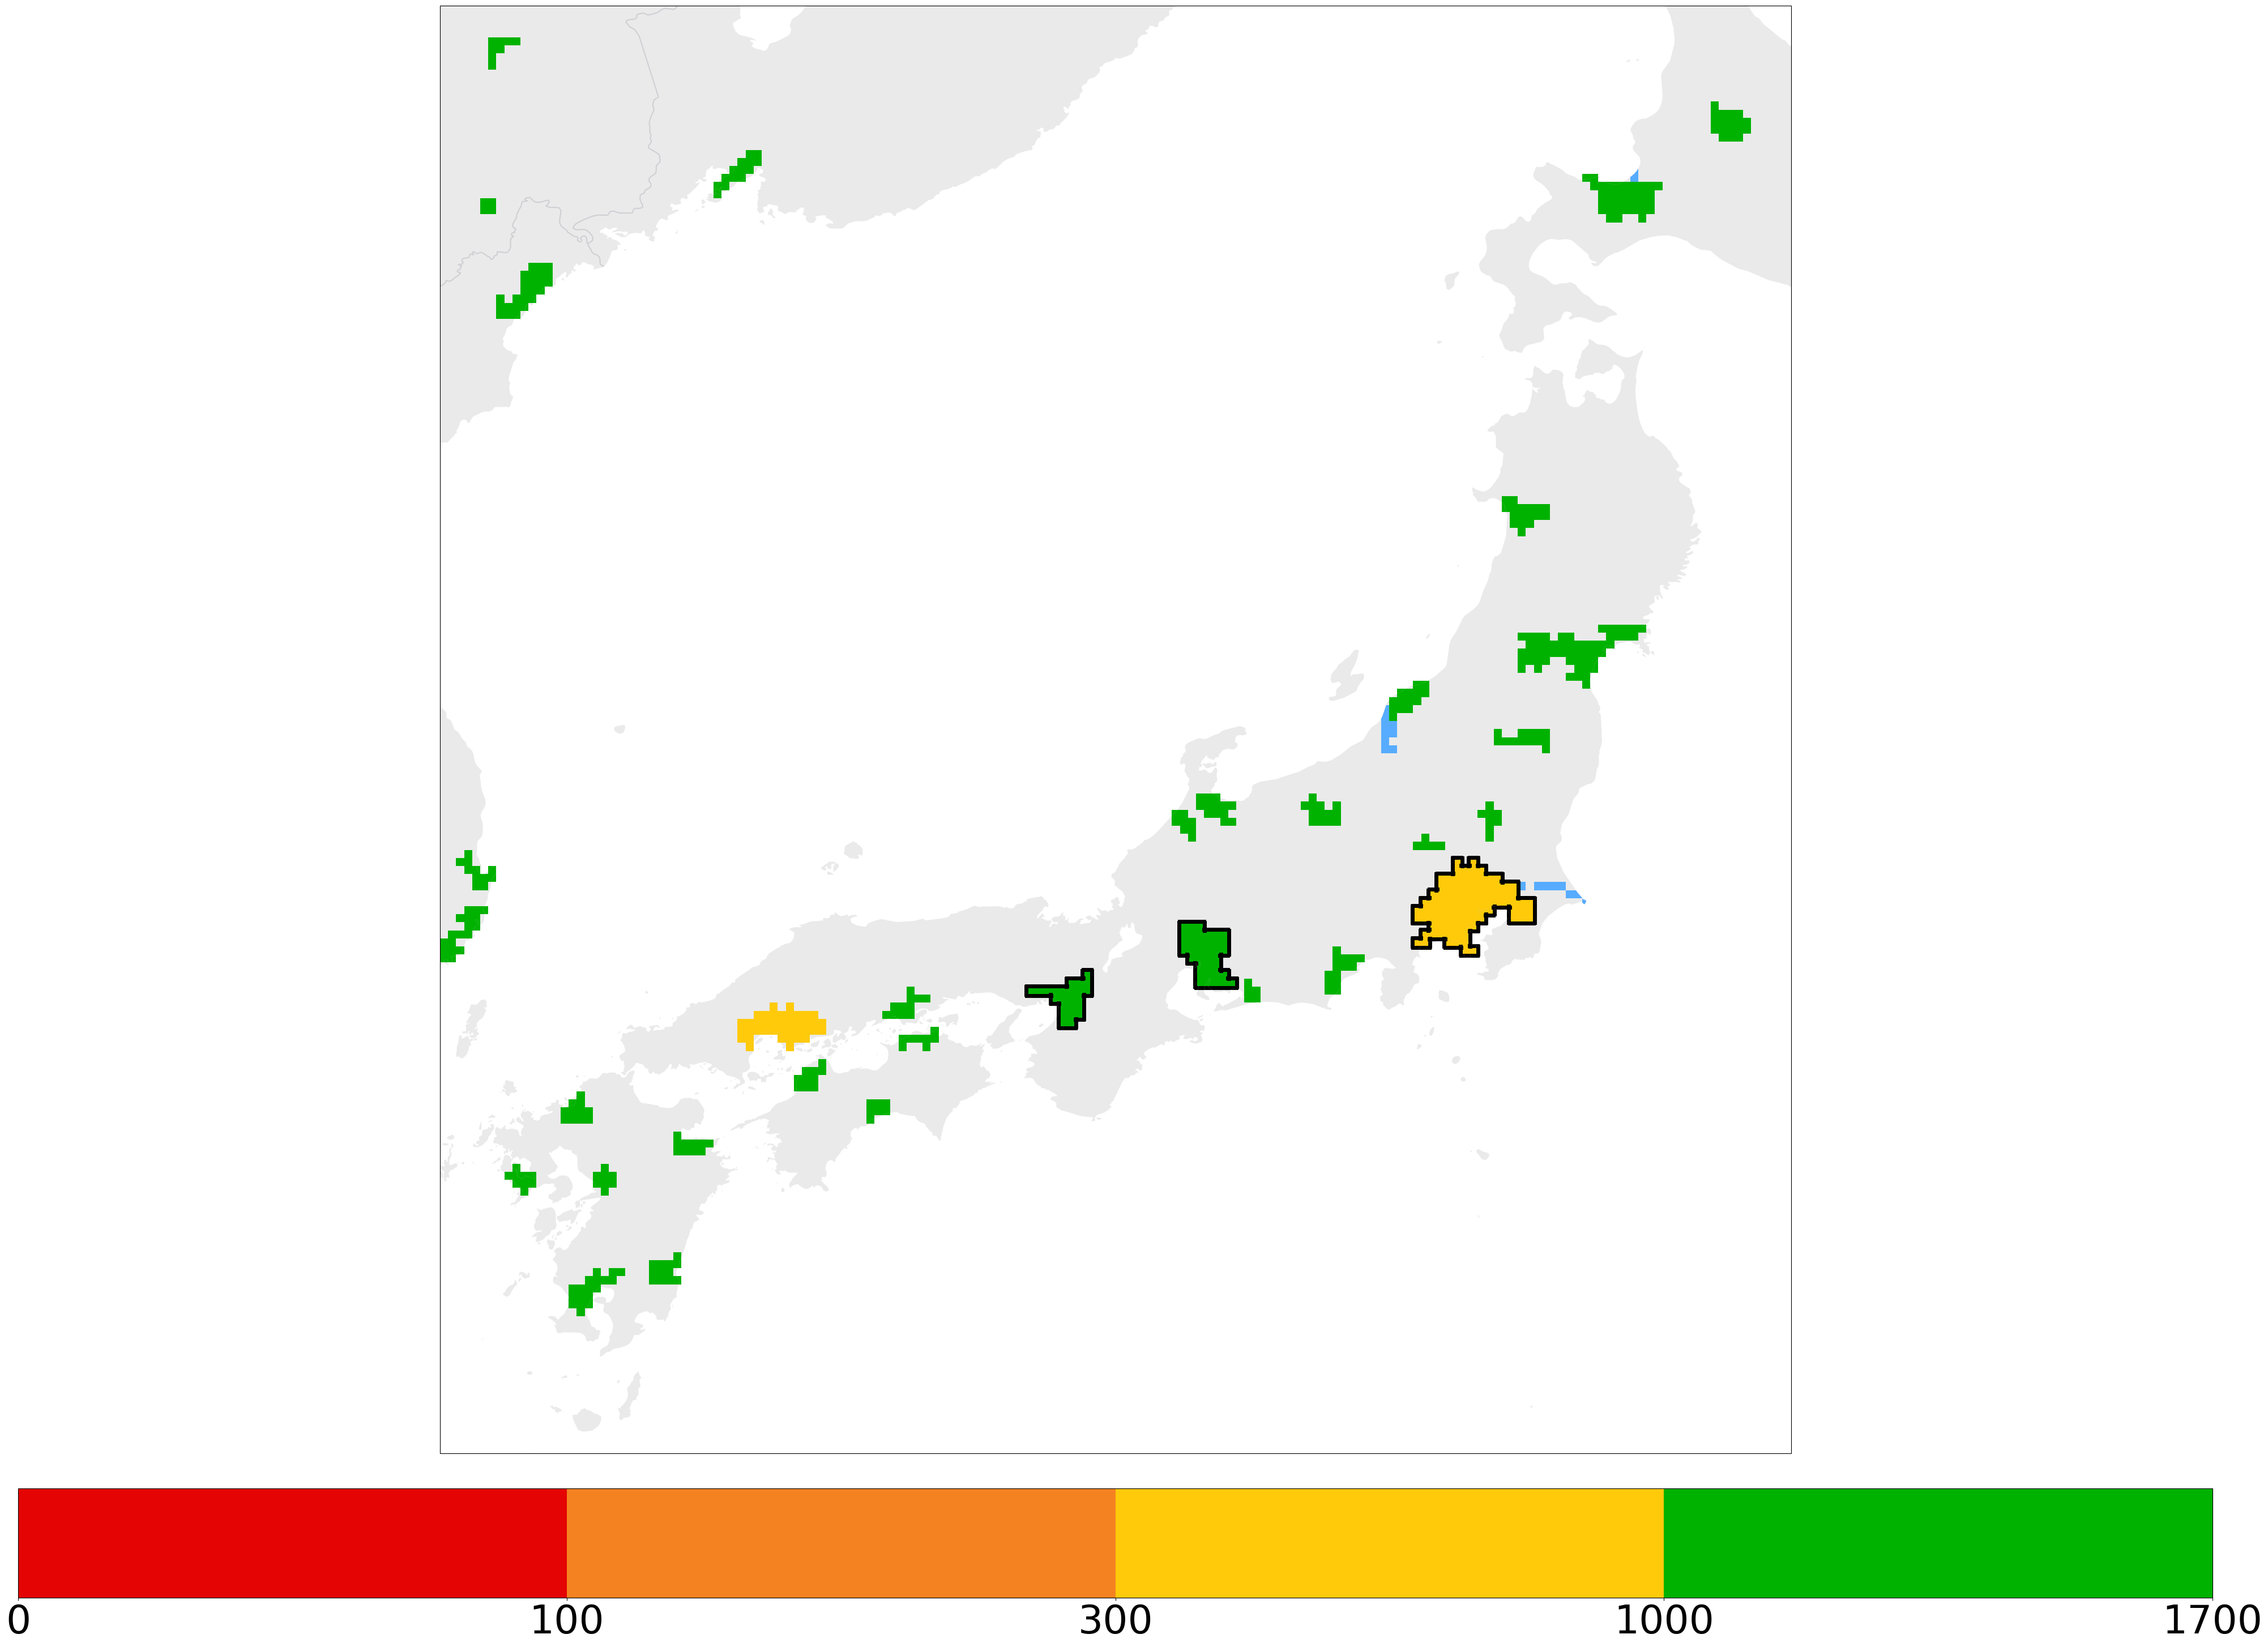

In [3]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import os
import matplotlib.colors as mcolors

def geography(left, right, bottom, top):
    #
    resolution = 12
    #
    upperindex = (90-top)*resolution
    lowerindex = (90-bottom)*resolution
    leftindex = (180+left)*resolution
    rightindex = (180+right)*resolution
    #
    rgnshape = (lowerindex-upperindex, rightindex-leftindex)
    #
    img_extent = (left, right, bottom, top)
    
    return upperindex, lowerindex, leftindex, rightindex, rgnshape, img_extent

def draw_mask_sotowaku_outer(extent, mask_cropped, ax=None, sotowaku_color='#dc143c', linewidth=5, padding=0.1, pop_thres=5e6):
    """
    zorder = 0: デフォルトの最背面(gridをzorder=0に設定)
    zorder = 1: 赤色の外枠(citymask)
    
    extent: (x_left, x_right, y_bottom, y_top)
    mask_cropped: マスクされた都市域の2D配列
    ax: プロットする軸
    sotowaku_color: 枠線の色
    linewidth: 枠線の太さ
    padding: 枠線を外側にシフトさせる量（度単位）
    """
    mask_cropped = np.ma.filled(mask_cropped, 0)

    # delta
    delta = 360/4320
    x_left = extent[0]
    y_top = extent[3]
    
    # outer
    upper_indices = []
    lower_indices = []
    left_indices = []
    right_indices = []
    rows, cols = mask_cropped.shape
    for i in range(rows-1):
        for j in range(cols-1):
            if mask_cropped[i, j] > pop_thres and mask_cropped[i, j] != 0:
                if i > 0 and mask_cropped[i-1, j] == 0:
                    upper_indices.append((i, j))
                if i < rows-1 and mask_cropped[i+1, j] == 0:
                    lower_indices.append((i, j))
                if j > 0 and mask_cropped[i, j-1] == 0:
                    left_indices.append((i, j))
                if j < cols-1 and mask_cropped[i, j+1] == 0:
                    right_indices.append((i, j))

    # extent
    projection = ccrs.PlateCarree()

    # city mask
    for up in upper_indices:
        x_index = x_left + delta*(up[1])
        y_index = y_top - delta*(up[0]) + padding * delta
        ax.plot([x_index, x_index+delta], [y_index, y_index], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # top
    for lo in lower_indices:
        x_index = x_left + delta*(lo[1])
        y_index = y_top - delta*(lo[0]+1) - padding * delta
        ax.plot([x_index, x_index+delta], [y_index, y_index], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # bottom
    for le in left_indices:
        x_index = x_left + delta*(le[1]) - padding * delta
        y_index = y_top - delta*(le[0]+1)
        ax.plot([x_index, x_index], [y_index, y_index+delta], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # left
    for ri in right_indices:
        x_index = x_left + delta*(ri[1]+1) + padding * delta
        y_index = y_top - delta*(ri[0]+1)
        ax.plot([x_index, x_index], [y_index, y_index+delta], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # right

    return ax

def main_plot(left, right, bottom, top, linewidth=5, padding=0.1):
    h08dir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08'
    upperindex, lowerindex, leftindex, rightindex, rgnshape, img_extent = geography(left, right, bottom, top)
    
    # wsi/pre/population_m3year.ipynb
    population_path = f'{h08dir}/wsi/dat/population/population_threshold_world.npy'
    population = np.load(population_path)
    population_cropped = population[upperindex:lowerindex, leftindex:rightindex]
    
    # discharge
    threshold = 5*1e6*2500
    riv_path = f'{h08dir}/wsi/dat/riv_out_/W5E5LR__00000000.gl5'
    rivout = np.fromfile(riv_path, dtype='float32').reshape(2160, 4320)
    rivout_cropped = rivout[upperindex:lowerindex, leftindex:rightindex] * 60 * 60 * 24 * 365 / 1000
    rivout_masked = np.ma.masked_where(rivout_cropped==0, rivout_cropped)
    rivout_thres = np.ma.masked_where(rivout_masked<threshold, rivout_masked)
    
    # wsi/pre/MPCY_citylonlat_citygrid.ipynb
    grid_path = f'{h08dir}/wsi/dat/cmy/world_citygrid_100km_abandon.npy'
    citygrid = np.load(grid_path)
    citygrid_masked = np.ma.masked_where(citygrid==0, citygrid)
    
    region = citygrid_masked[upperindex:lowerindex, leftindex:rightindex]
    region_masked = np.ma.masked_where(region==0, region)
    
    bounds = [0, 100, 300, 1000, 1700]
    #cmap = mcolors.ListedColormap(['#e40404', '#f58220', '#feca0a', '#89989c'])
    #cmap = mcolors.ListedColormap(['#e40404', '#f58220', '#feca0a', '#f0fff0'])
    cmap = mcolors.ListedColormap(['#e40404', '#f58220', '#feca0a', '#00b200'])
    norm = mcolors.BoundaryNorm(bounds, cmap.N)
    
    plt.rcParams["font.size"] = 50
    projection = ccrs.PlateCarree()
    fig, ax = plt.subplots(figsize=(50,40), subplot_kw={'projection': projection})

    #river_cmap = mcolors.ListedColormap(['#60c9f8'])
    #river_cmap = mcolors.ListedColormap(['#3eb1c8'])
    river_cmap = mcolors.ListedColormap(['#57acff'])
    imr = ax.imshow(rivout_thres, 
                    extent=img_extent,
                    cmap=river_cmap,
                    transform=projection,
                    zorder=-2
                   )
    
    imd = ax.imshow(region_masked, 
                  cmap= cmap,
                  norm = norm,
                  extent=img_extent,
                  transform=projection, 
                 )
    
    ax.add_feature(cfeature.LAND, edgecolor='none', facecolor='#eaeaea', zorder=-3)
    ax.add_feature(cfeature.OCEAN, edgecolor='none', facecolor='#ffffff')
    ax.add_feature(cfeature.LAKES, edgecolor='none', facecolor='#ffffff', zorder=-1)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.1,edgecolor='#d0cfd4')
    ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=1.5, edgecolor='#d0cfd4', zorder=-3)
    ax.gridlines(visible=False)
    cbar = fig.colorbar(imd, ax=ax, orientation='horizontal', pad=0.02)
    draw_mask_sotowaku_outer(img_extent, population_cropped, ax=ax, sotowaku_color='black', linewidth=linewidth, padding=padding, pop_thres=5e6)
    plt.show()

left, right, bottom, top = 129, 143, 30, 45
main_plot(left, right, bottom, top)

In [18]:
####################################################################################
# This test code shows how new_basin_cities looks like
# basin at each city
distance=100
####################################################################################
h08dir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08'
basin_cities_path = f'{h08dir}/global_city/dat/riv_num_/basin_to_cities_{distance}km.json'

with open(basin_cities_path, 'r') as json_file:
    tmp = json.load(json_file)
    
sorted_keys = sorted(tmp.keys(), key=lambda k: float(k))

for key in sorted_keys:
    value = tmp[key]
    if 4 < len(value) < 10 and float(key) < 100:
        print(f'key{key}, len: {len(value)}')
        print(value)
        print('-----------------------------------------')

key2.0, len: 9
['28', '261', '480', '650', '729', '1101', '1333', '1434', '1491']
-----------------------------------------
key18.0, len: 7
['259', '408', '596', '615', '1127', '1130', '1690']
-----------------------------------------
key21.0, len: 7
['77', '122', '256', '656', '1060', '1513', '1625']
-----------------------------------------
key26.0, len: 9
['289', '547', '717', '771', '984', '1144', '1155', '1305', '1795']
-----------------------------------------
key35.0, len: 5
['95', '172', '211', '481', '548']
-----------------------------------------
key42.0, len: 5
['195', '238', '802', '1296', '1798']
-----------------------------------------
key43.0, len: 6
['77', '256', '655', '1625', '1646', '1792']
-----------------------------------------
key56.0, len: 5
['114', '627', '688', '1681', '1846']
-----------------------------------------
key65.0, len: 6
['502', '790', '1098', '1290', '1601', '1766']
-----------------------------------------
key75.0, len: 9
['251', '607', '625'

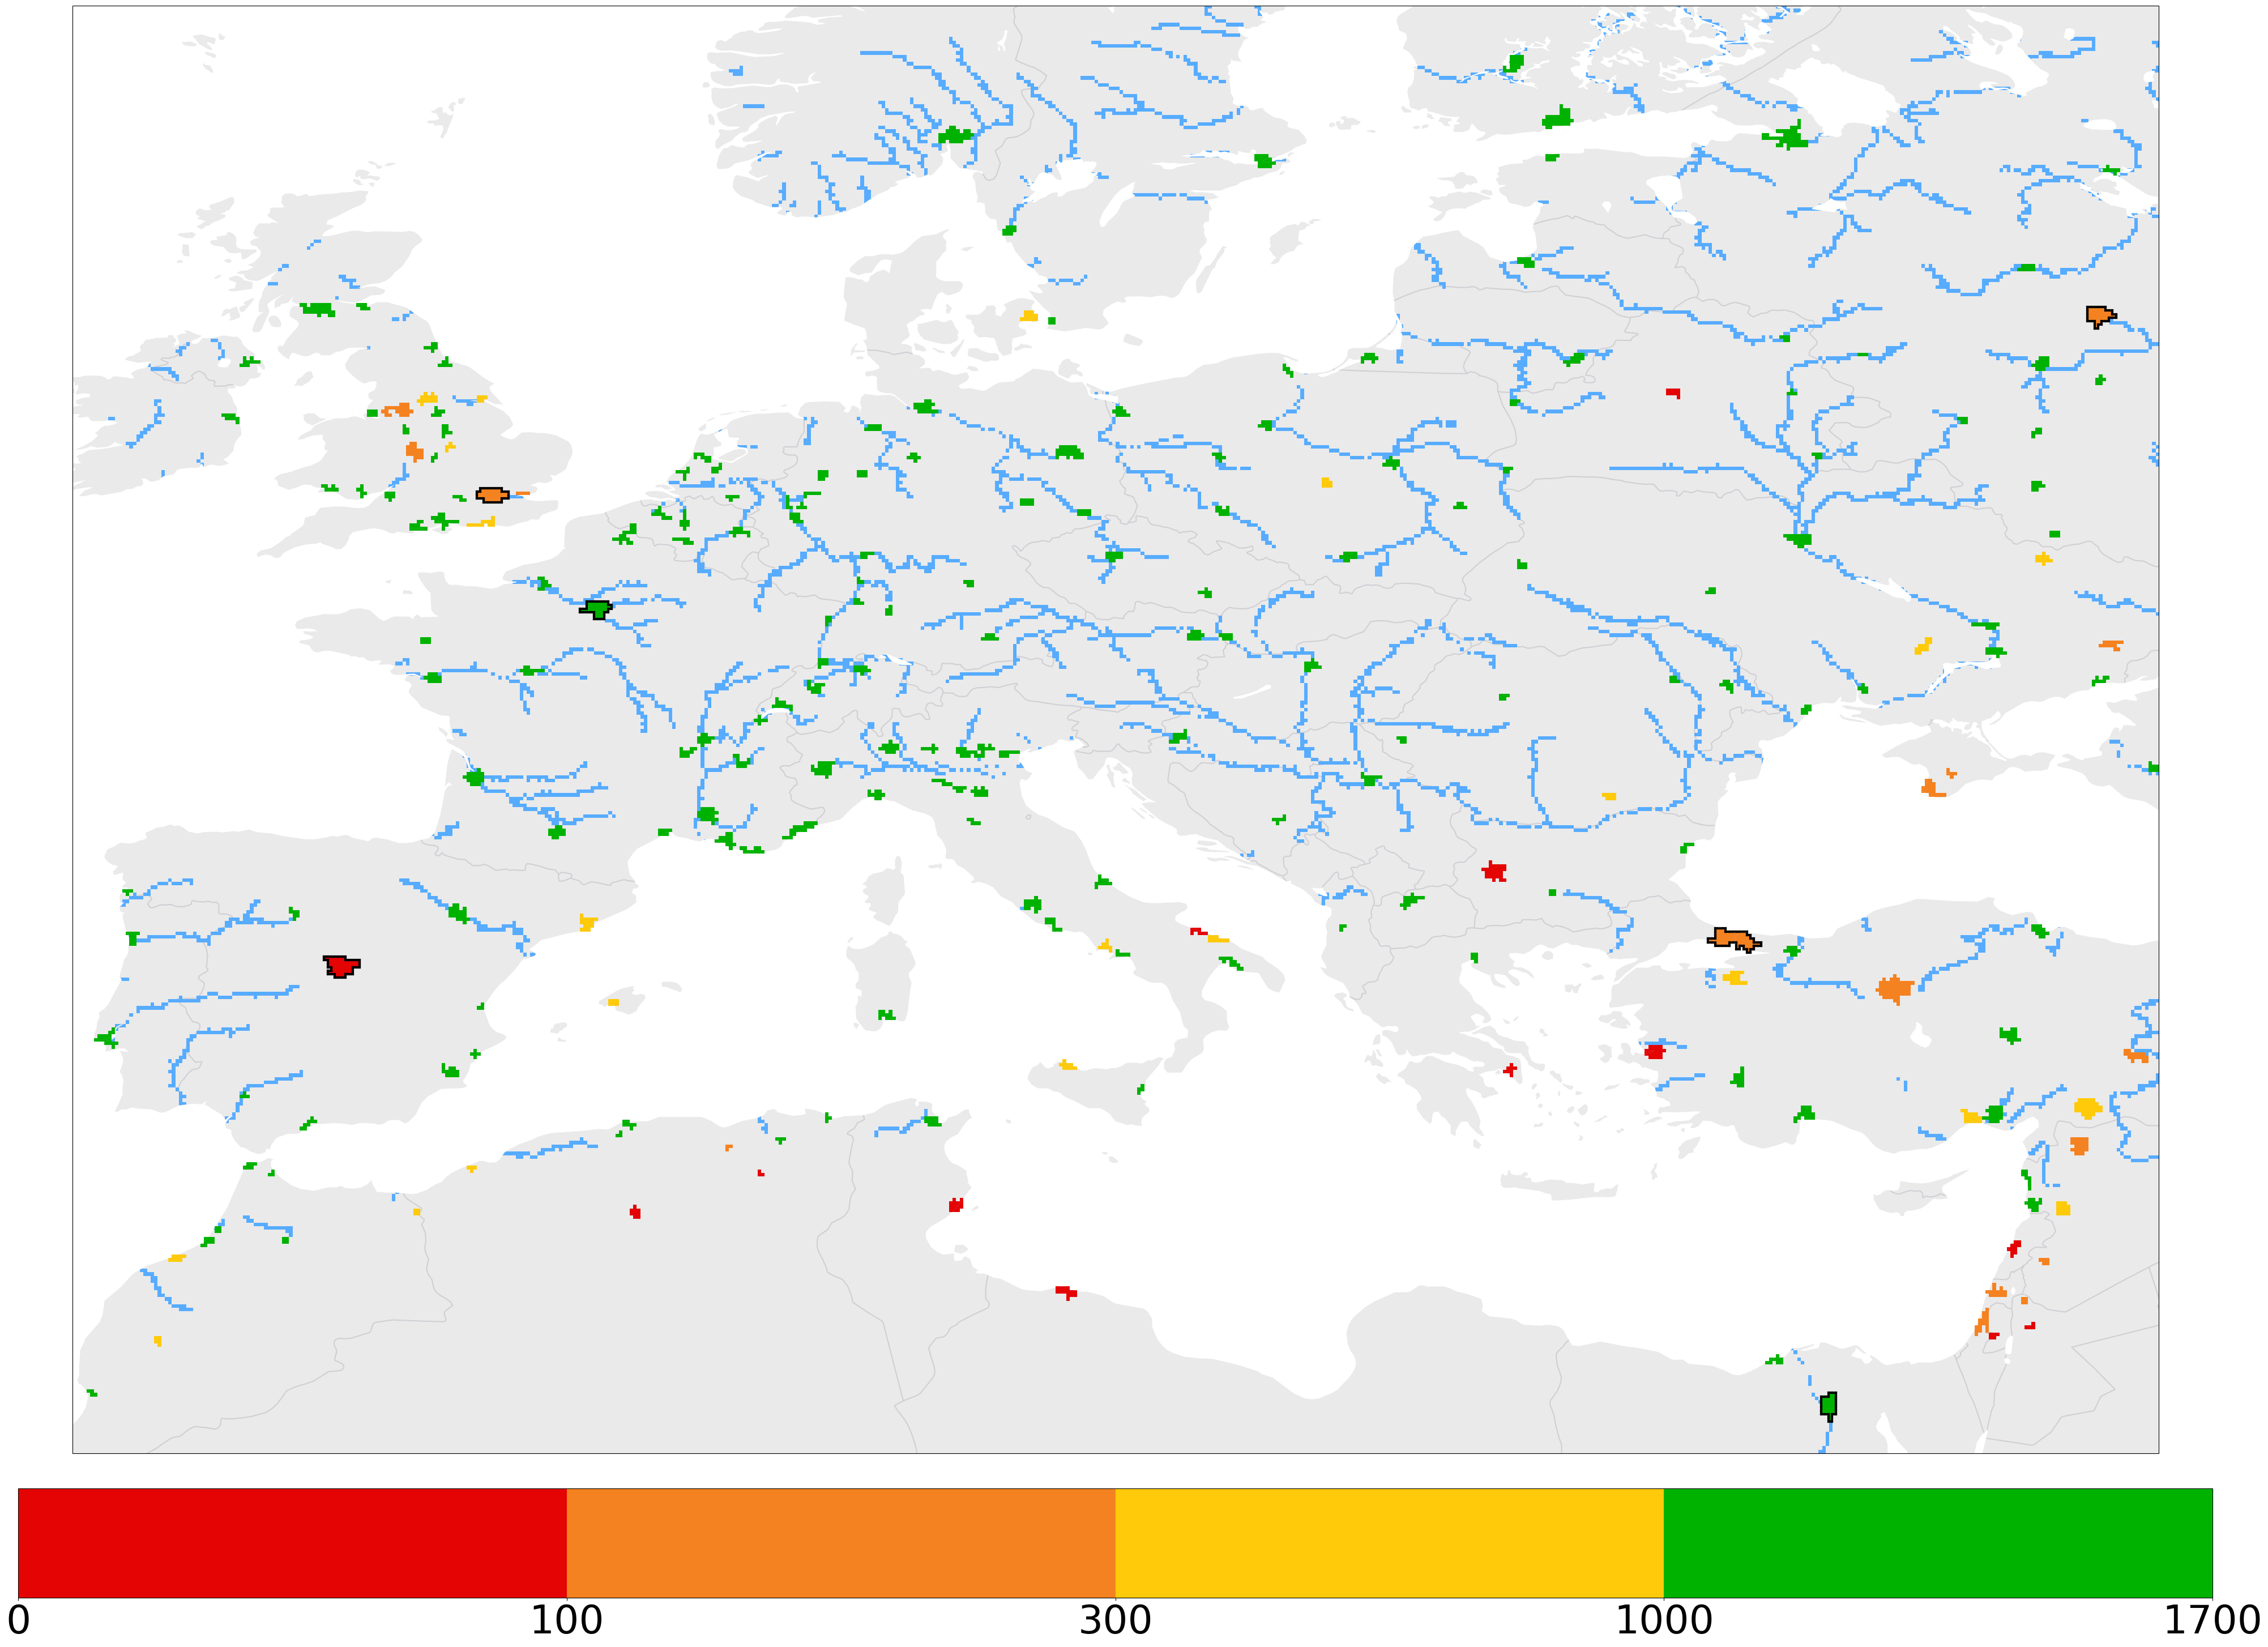

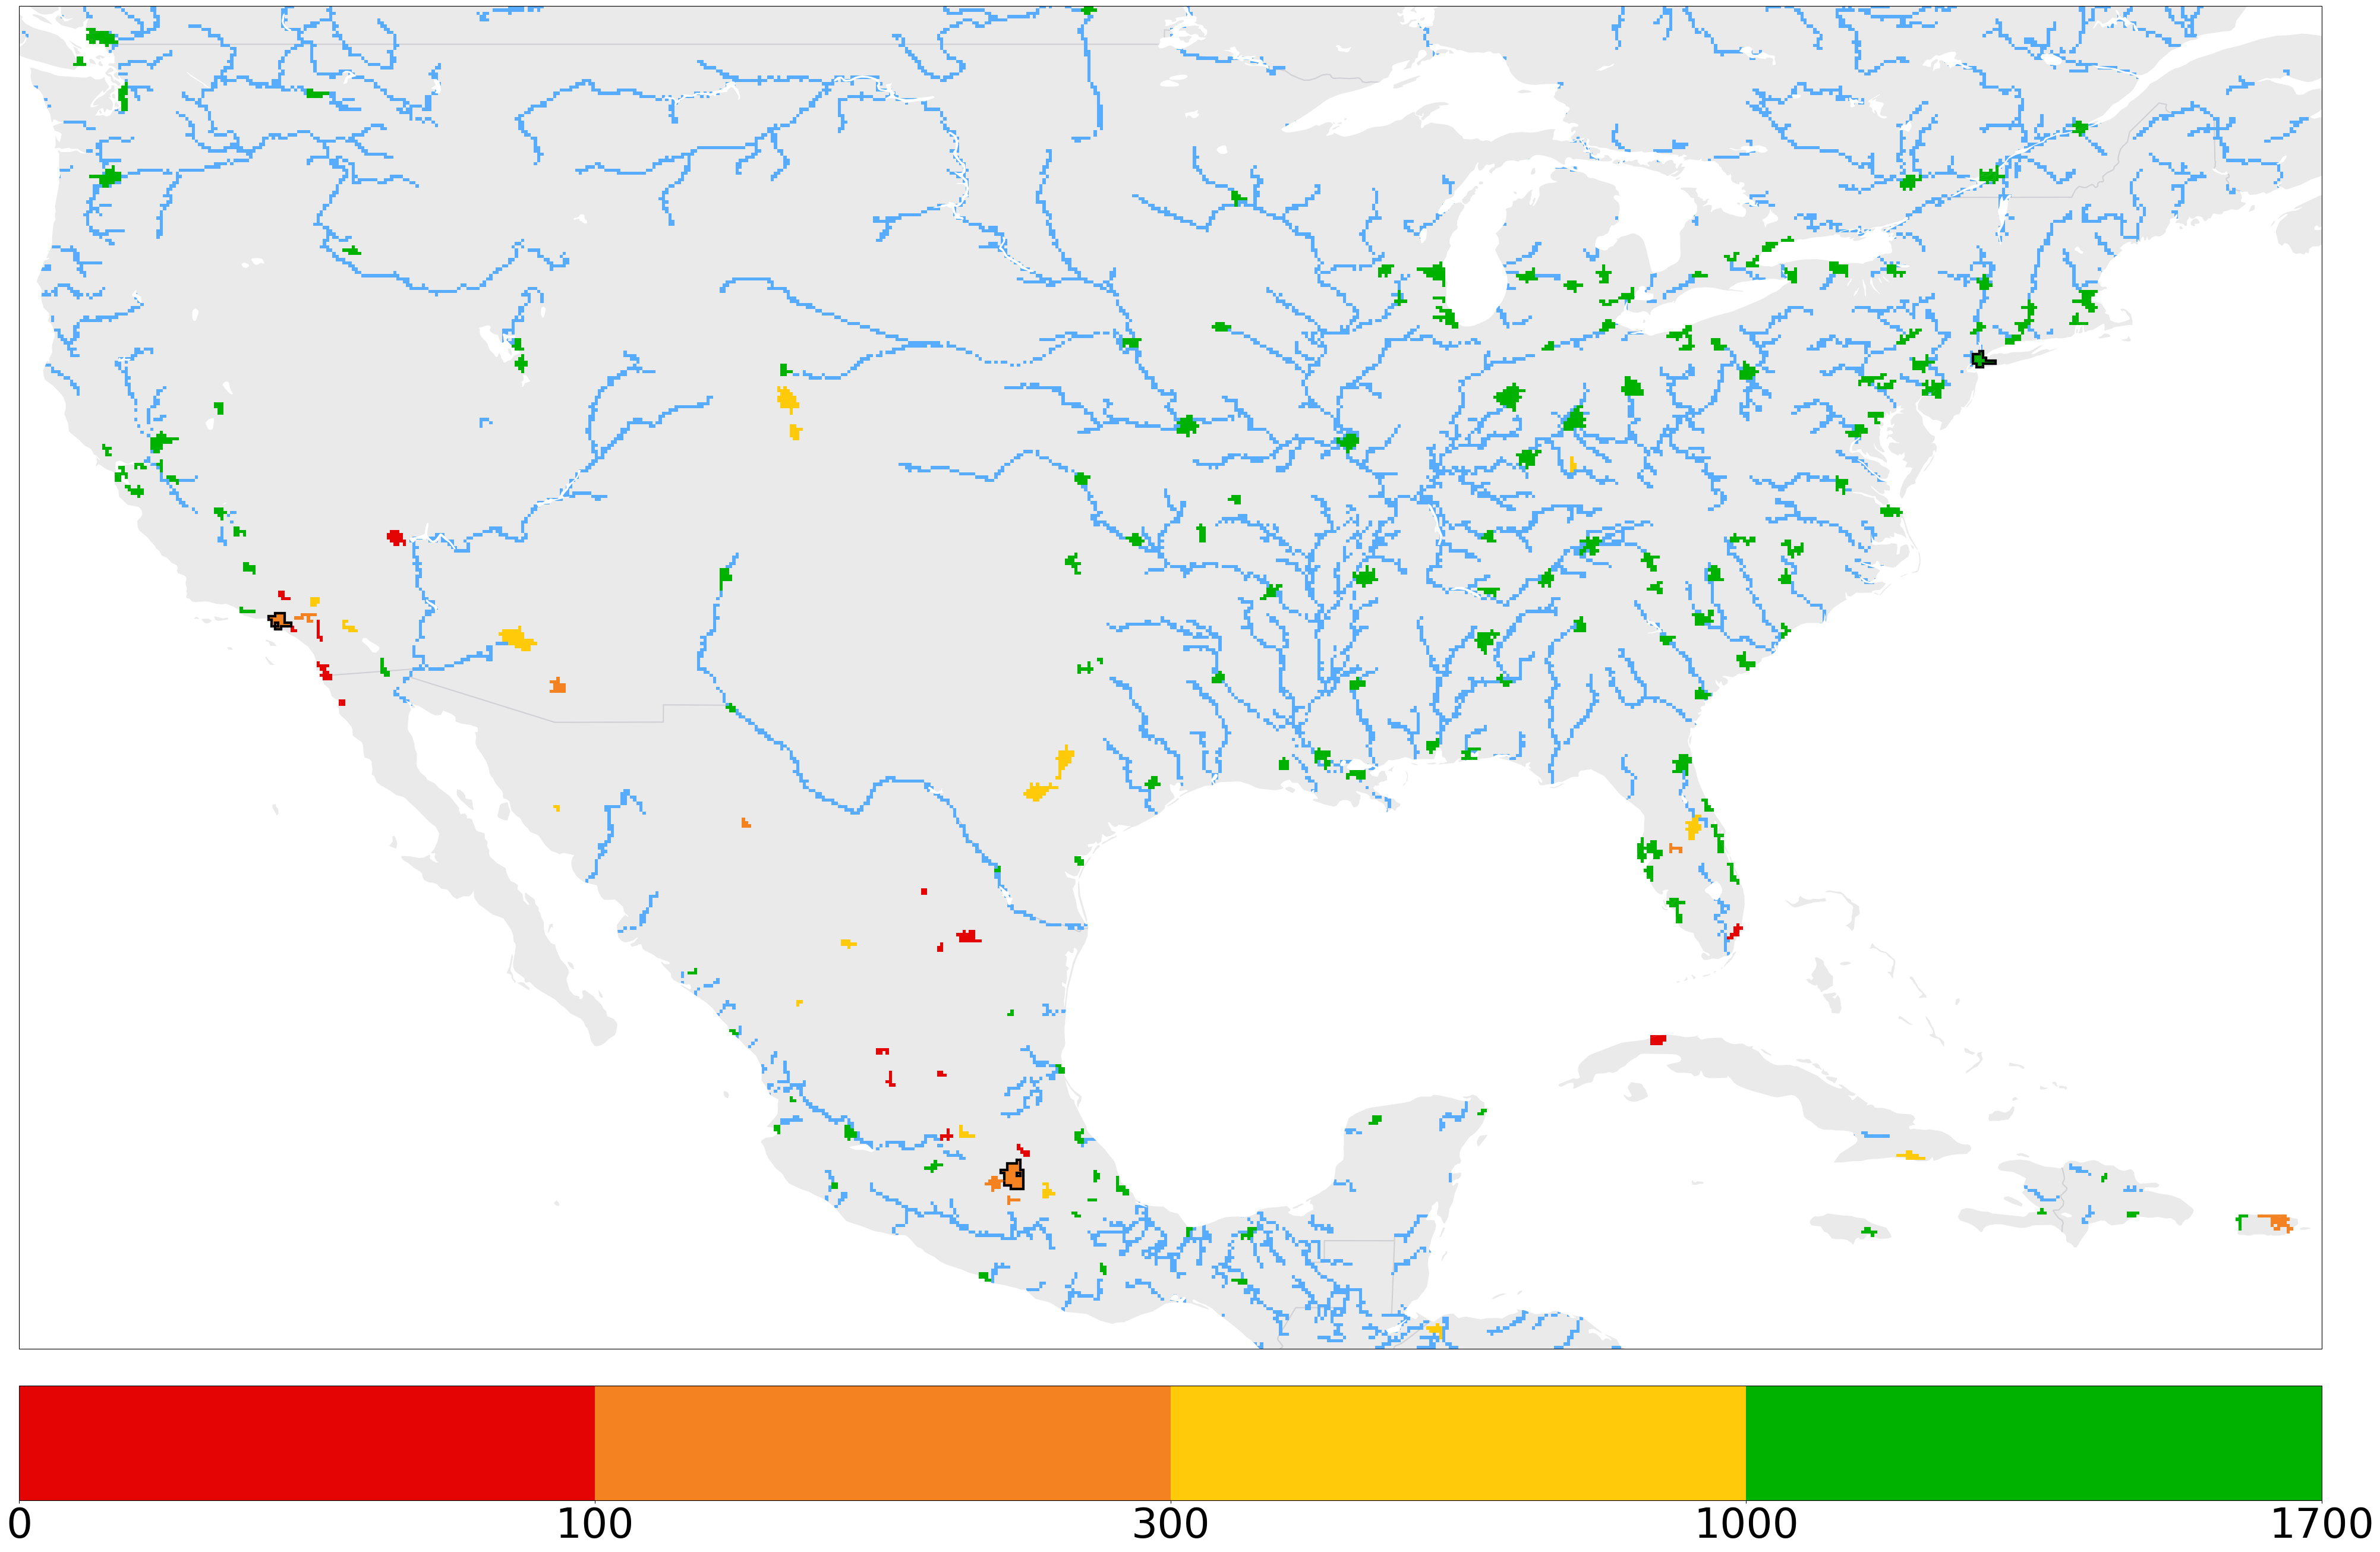

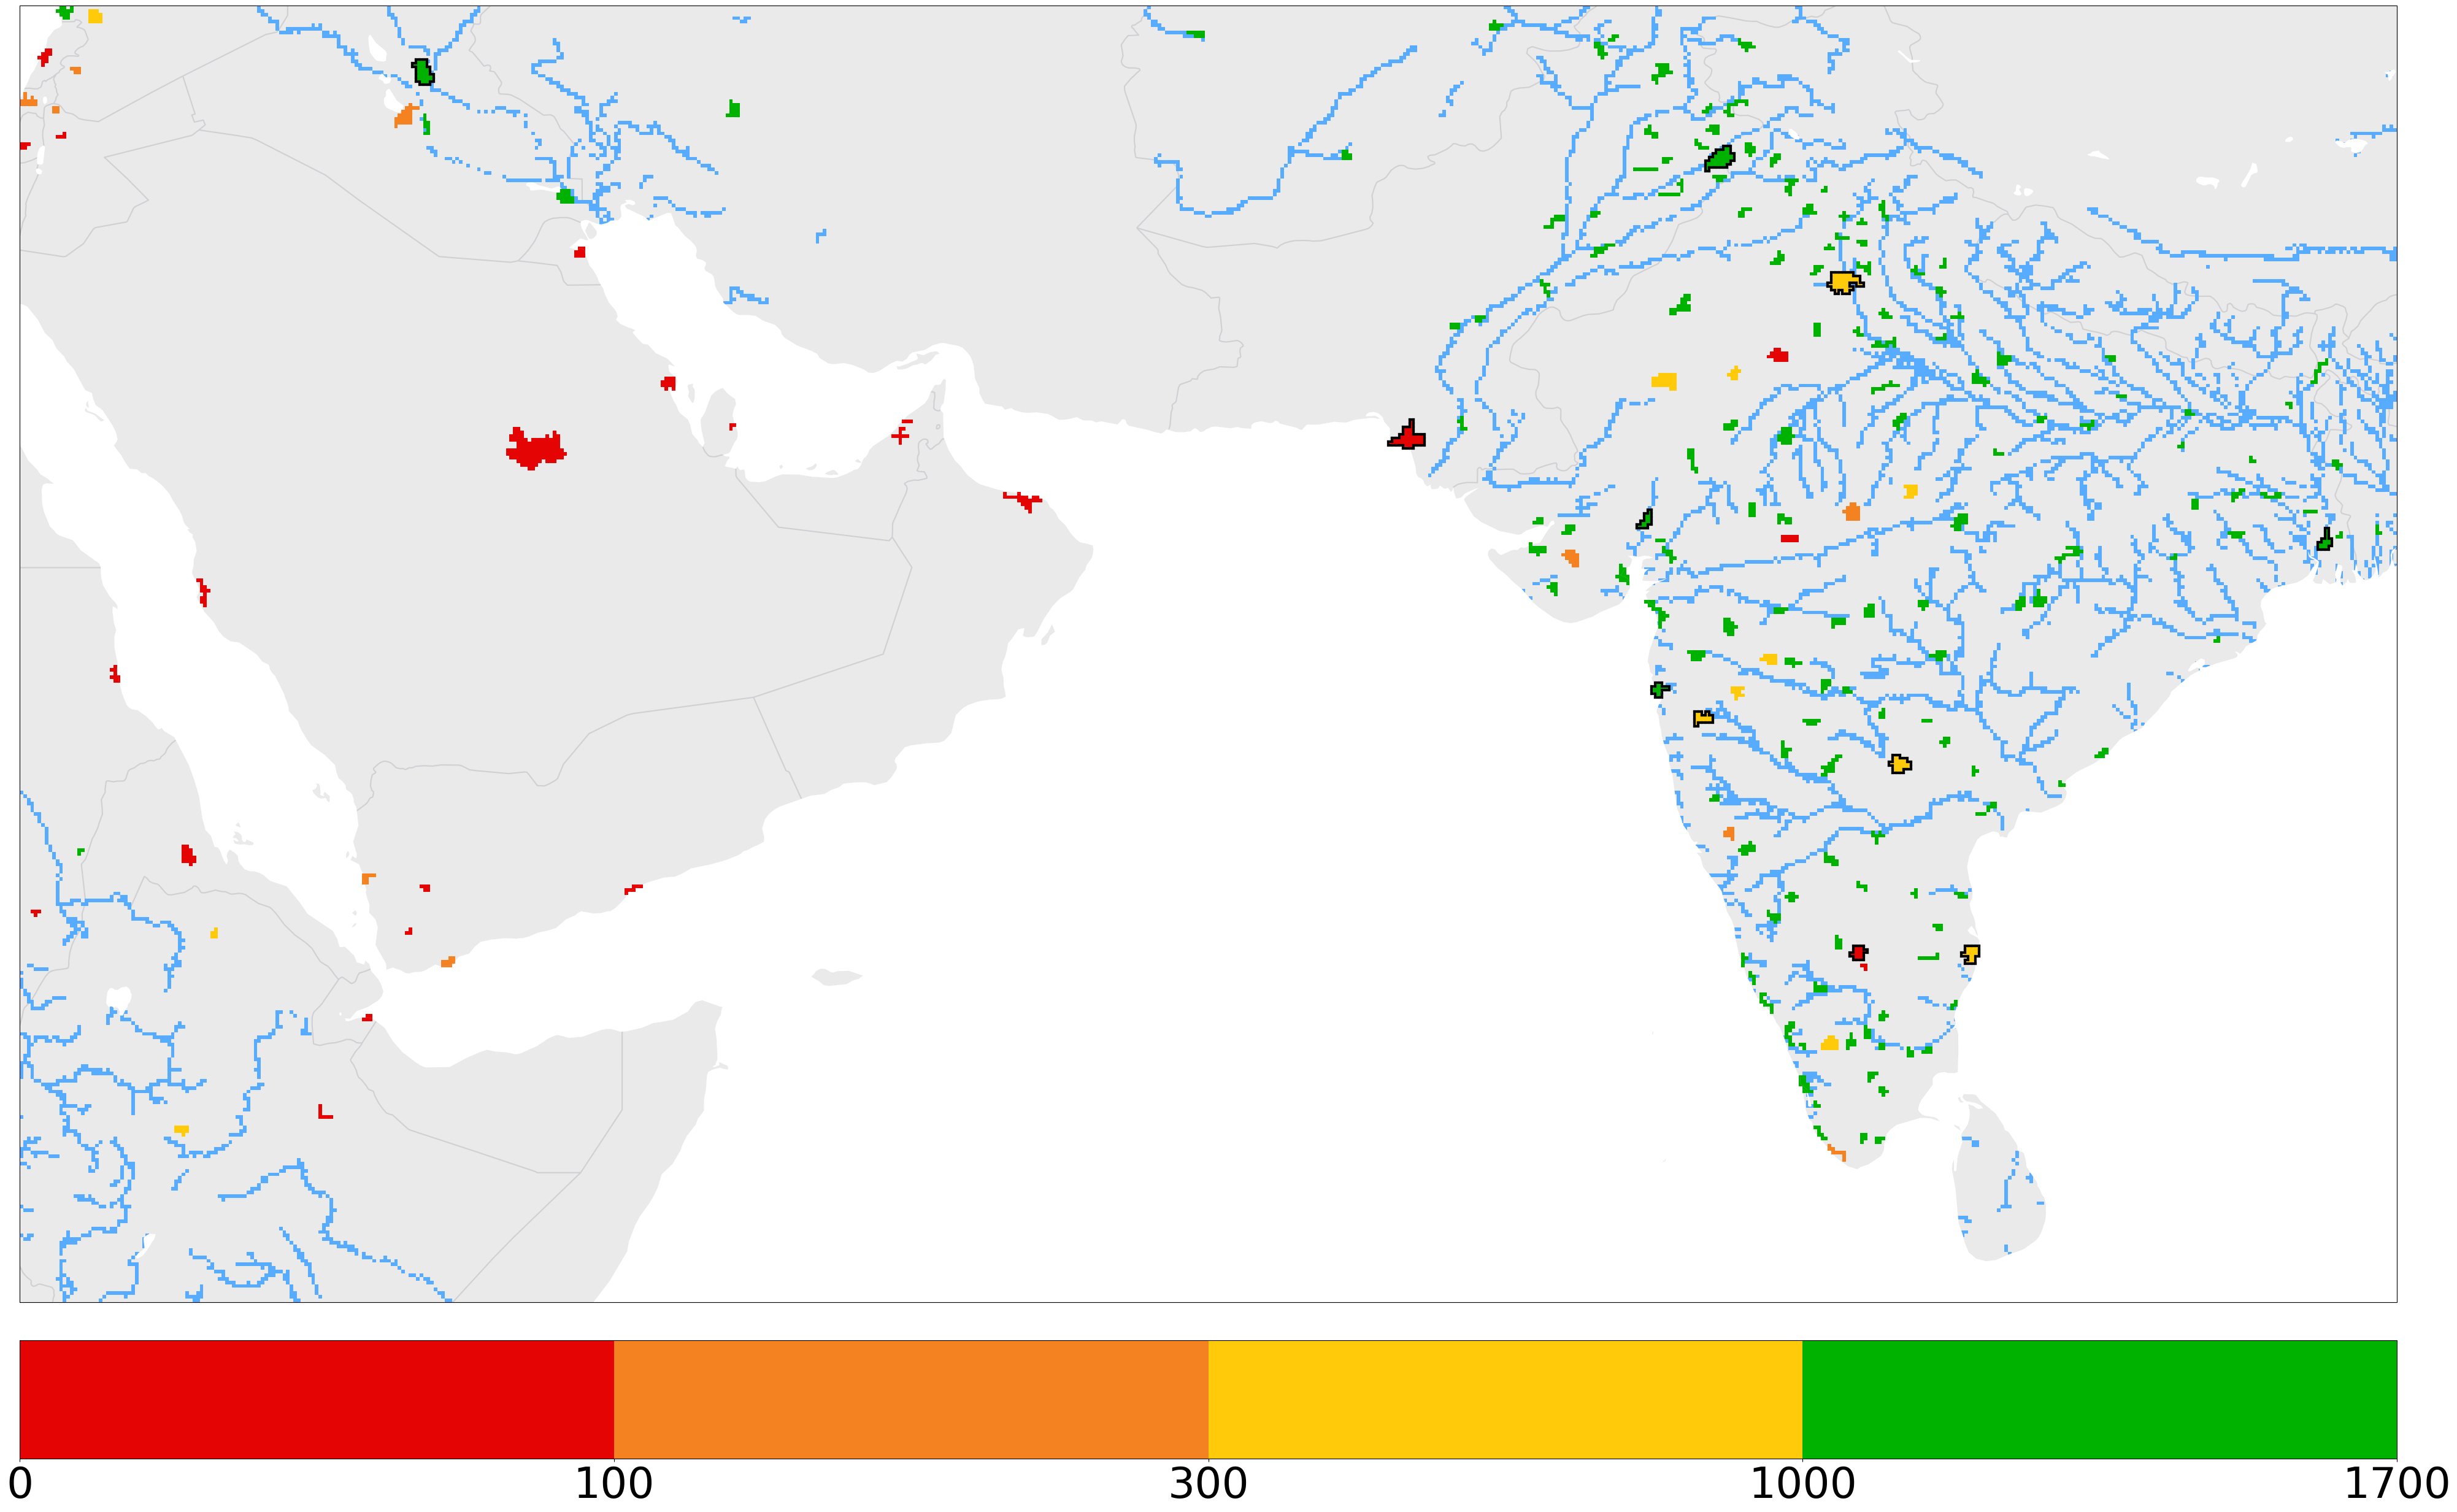

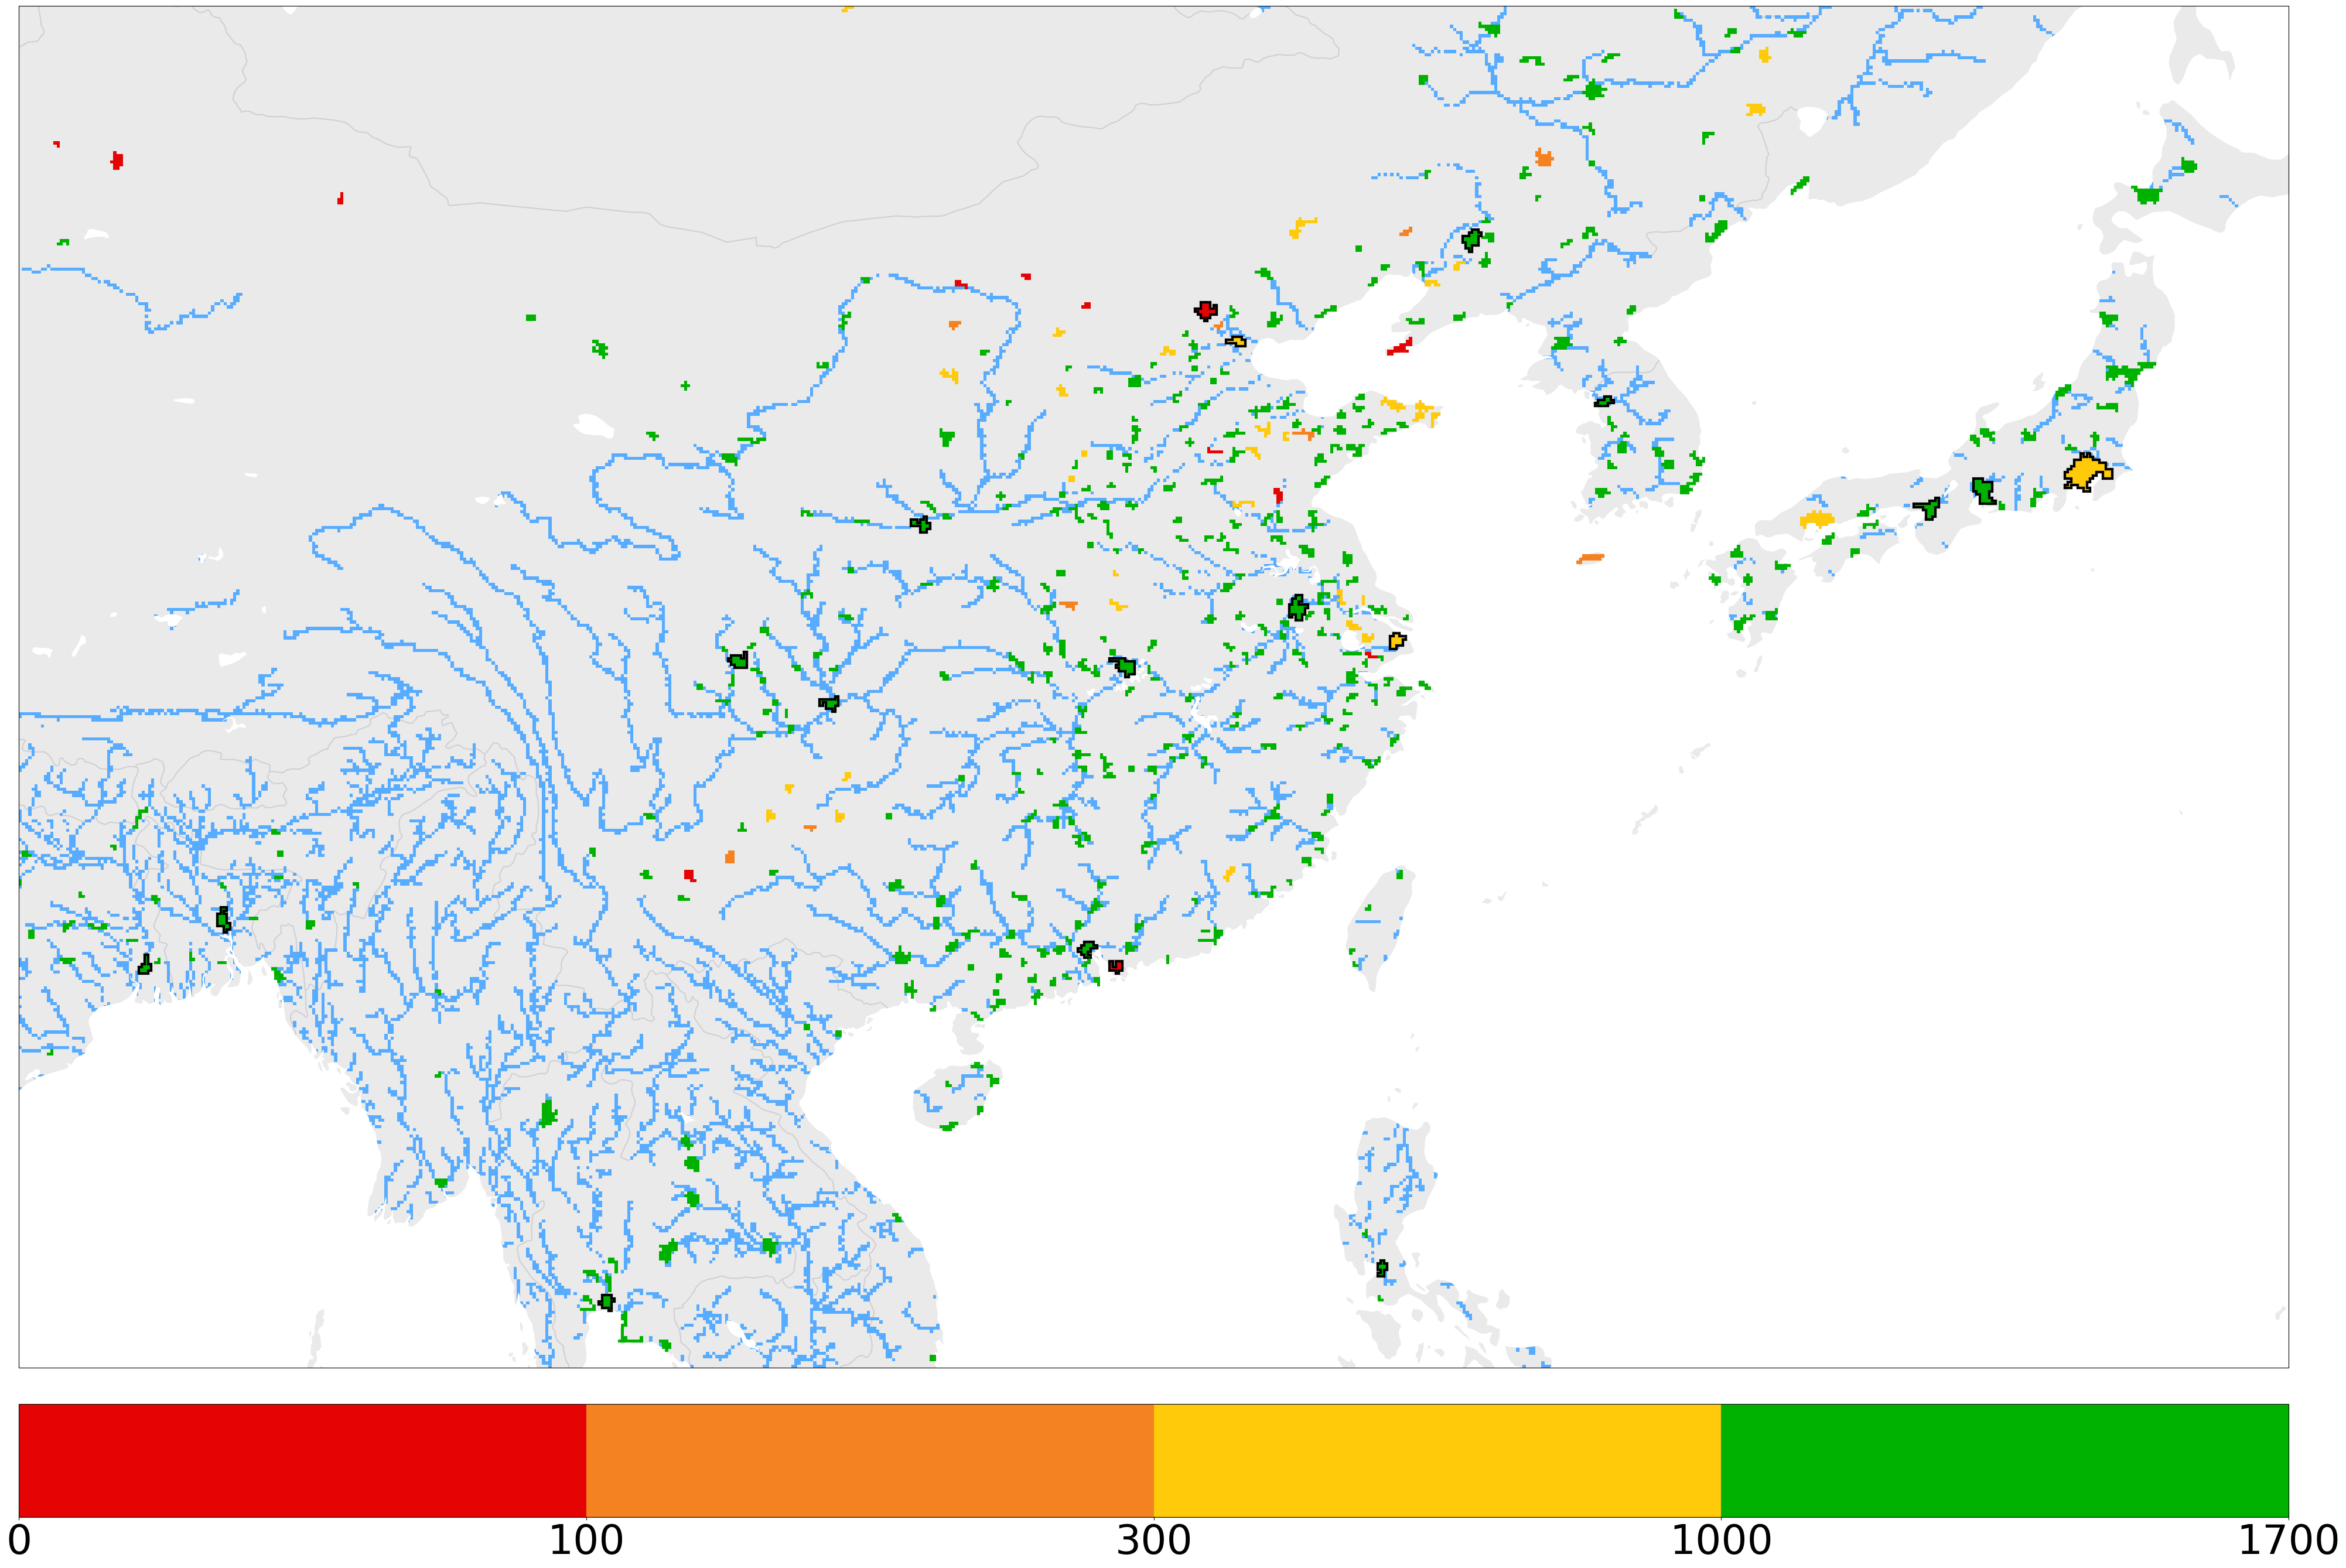

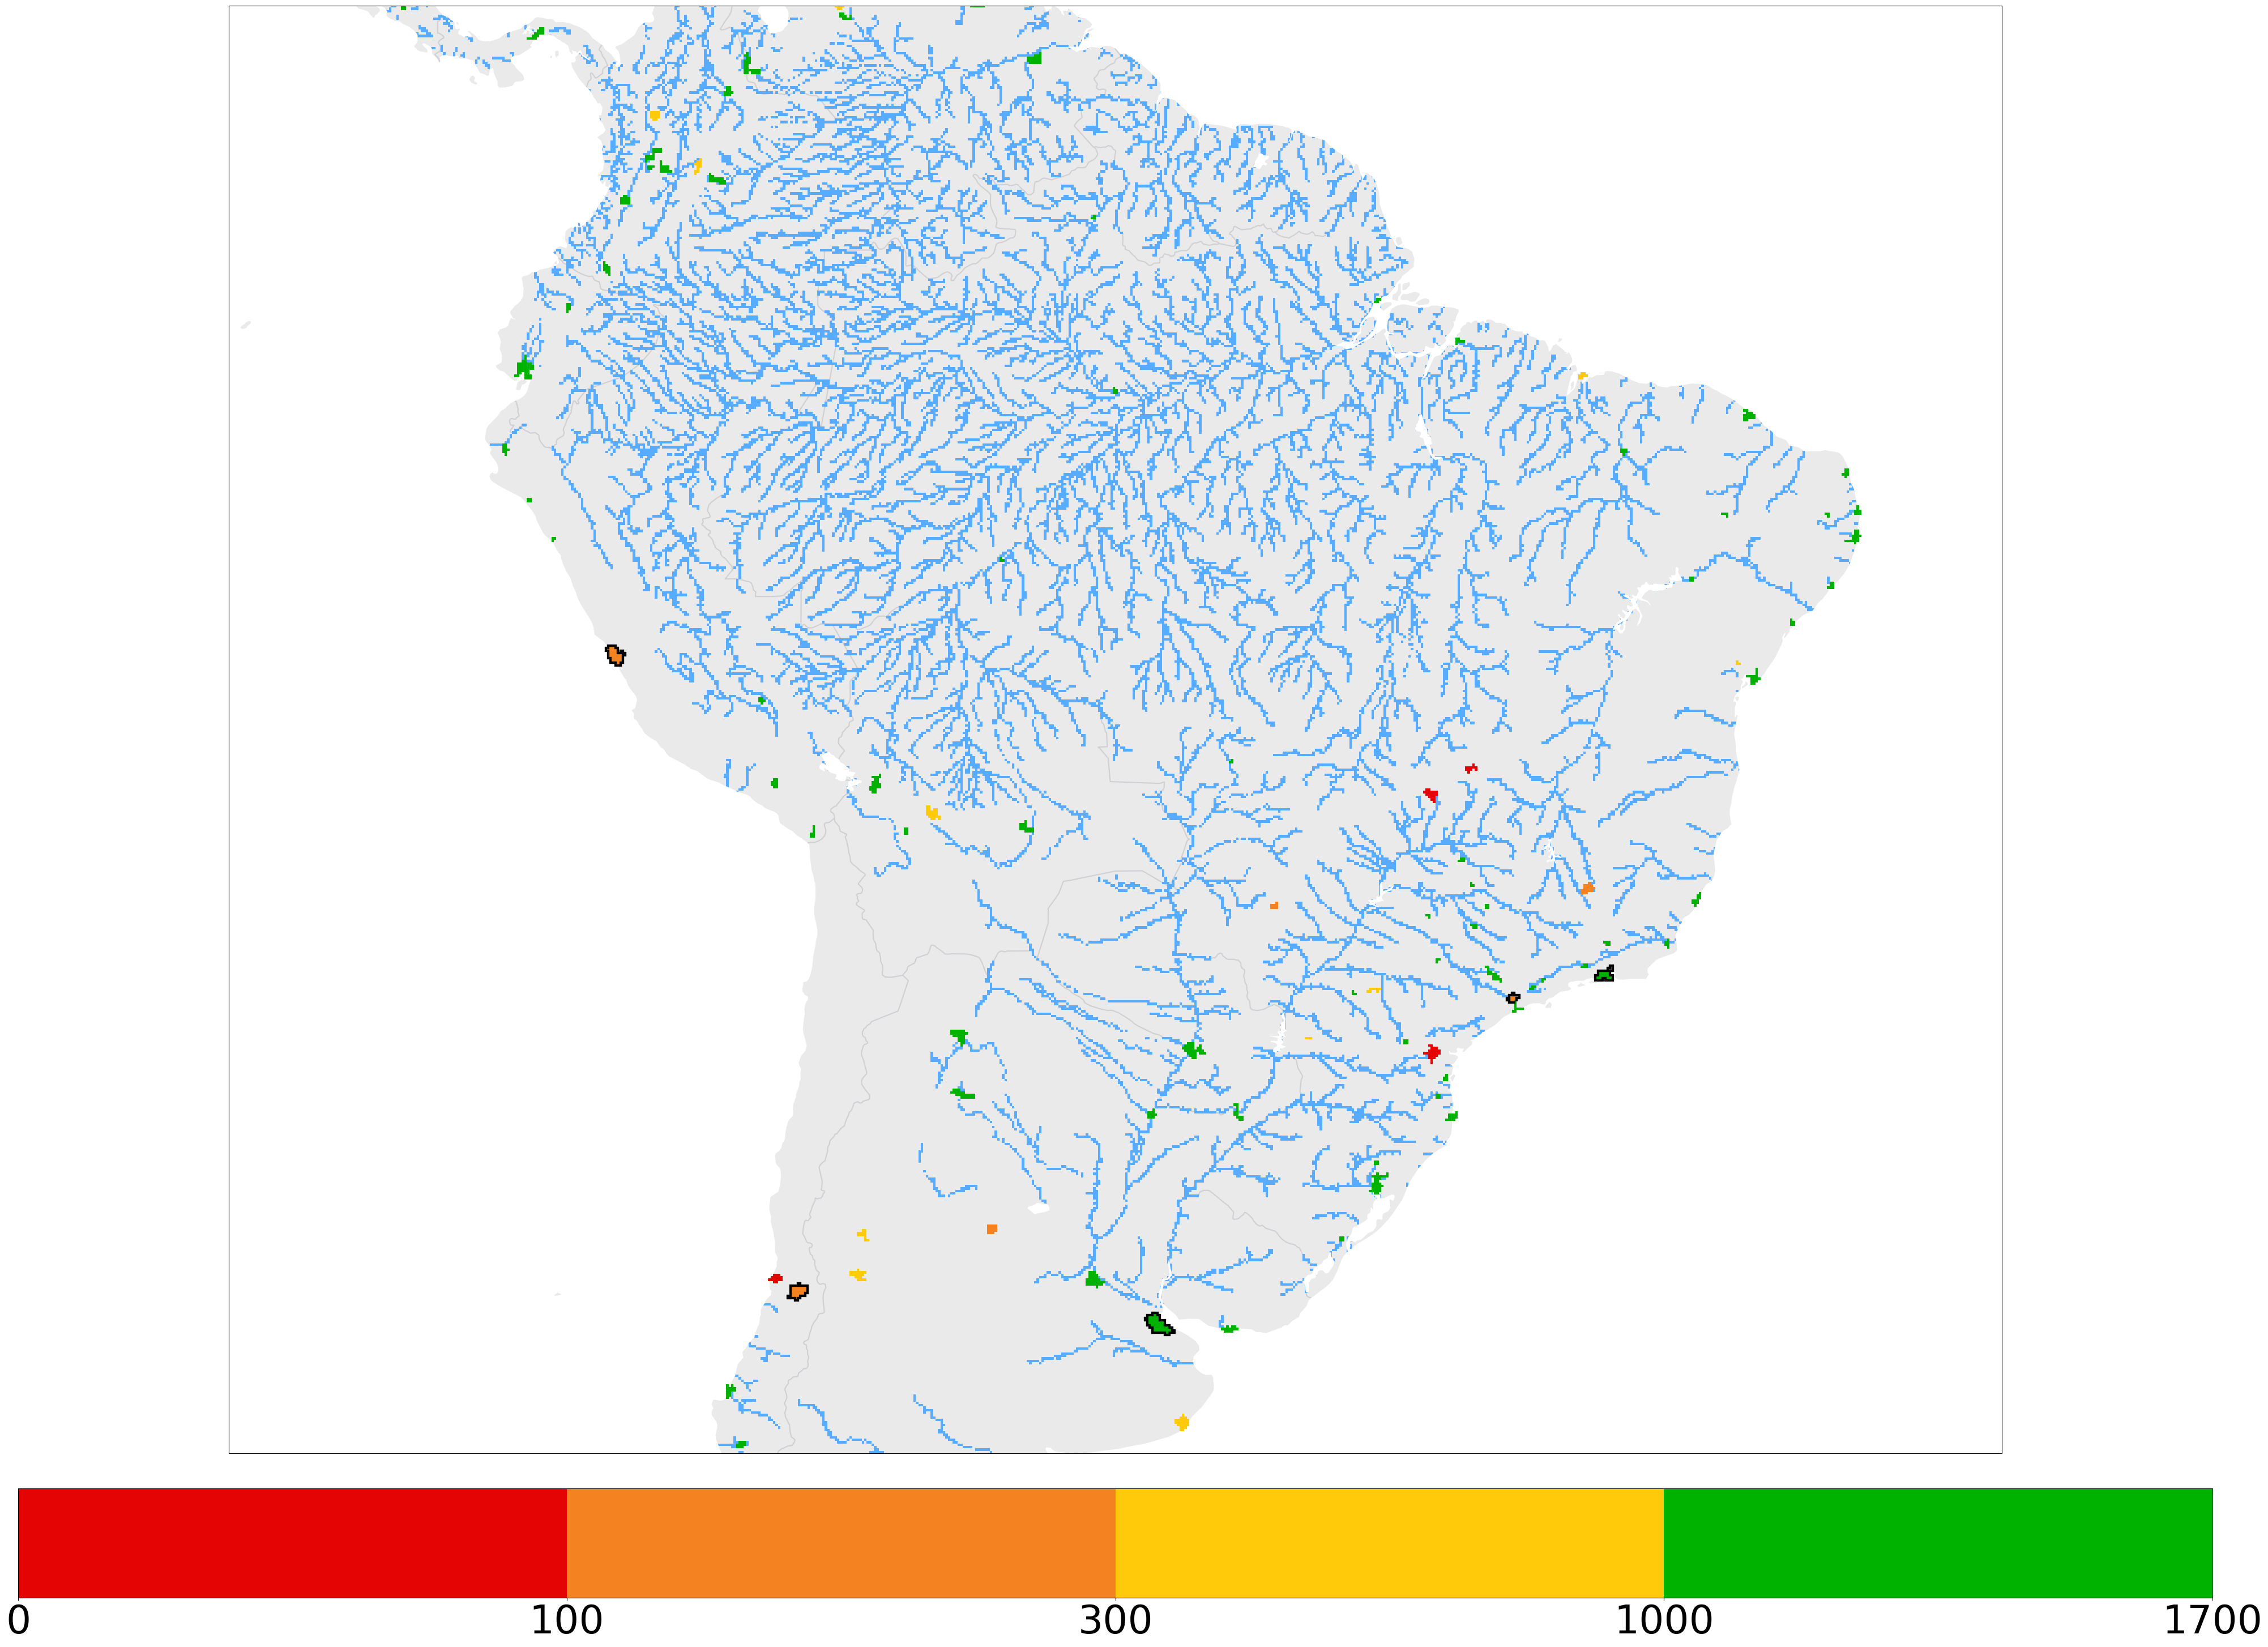

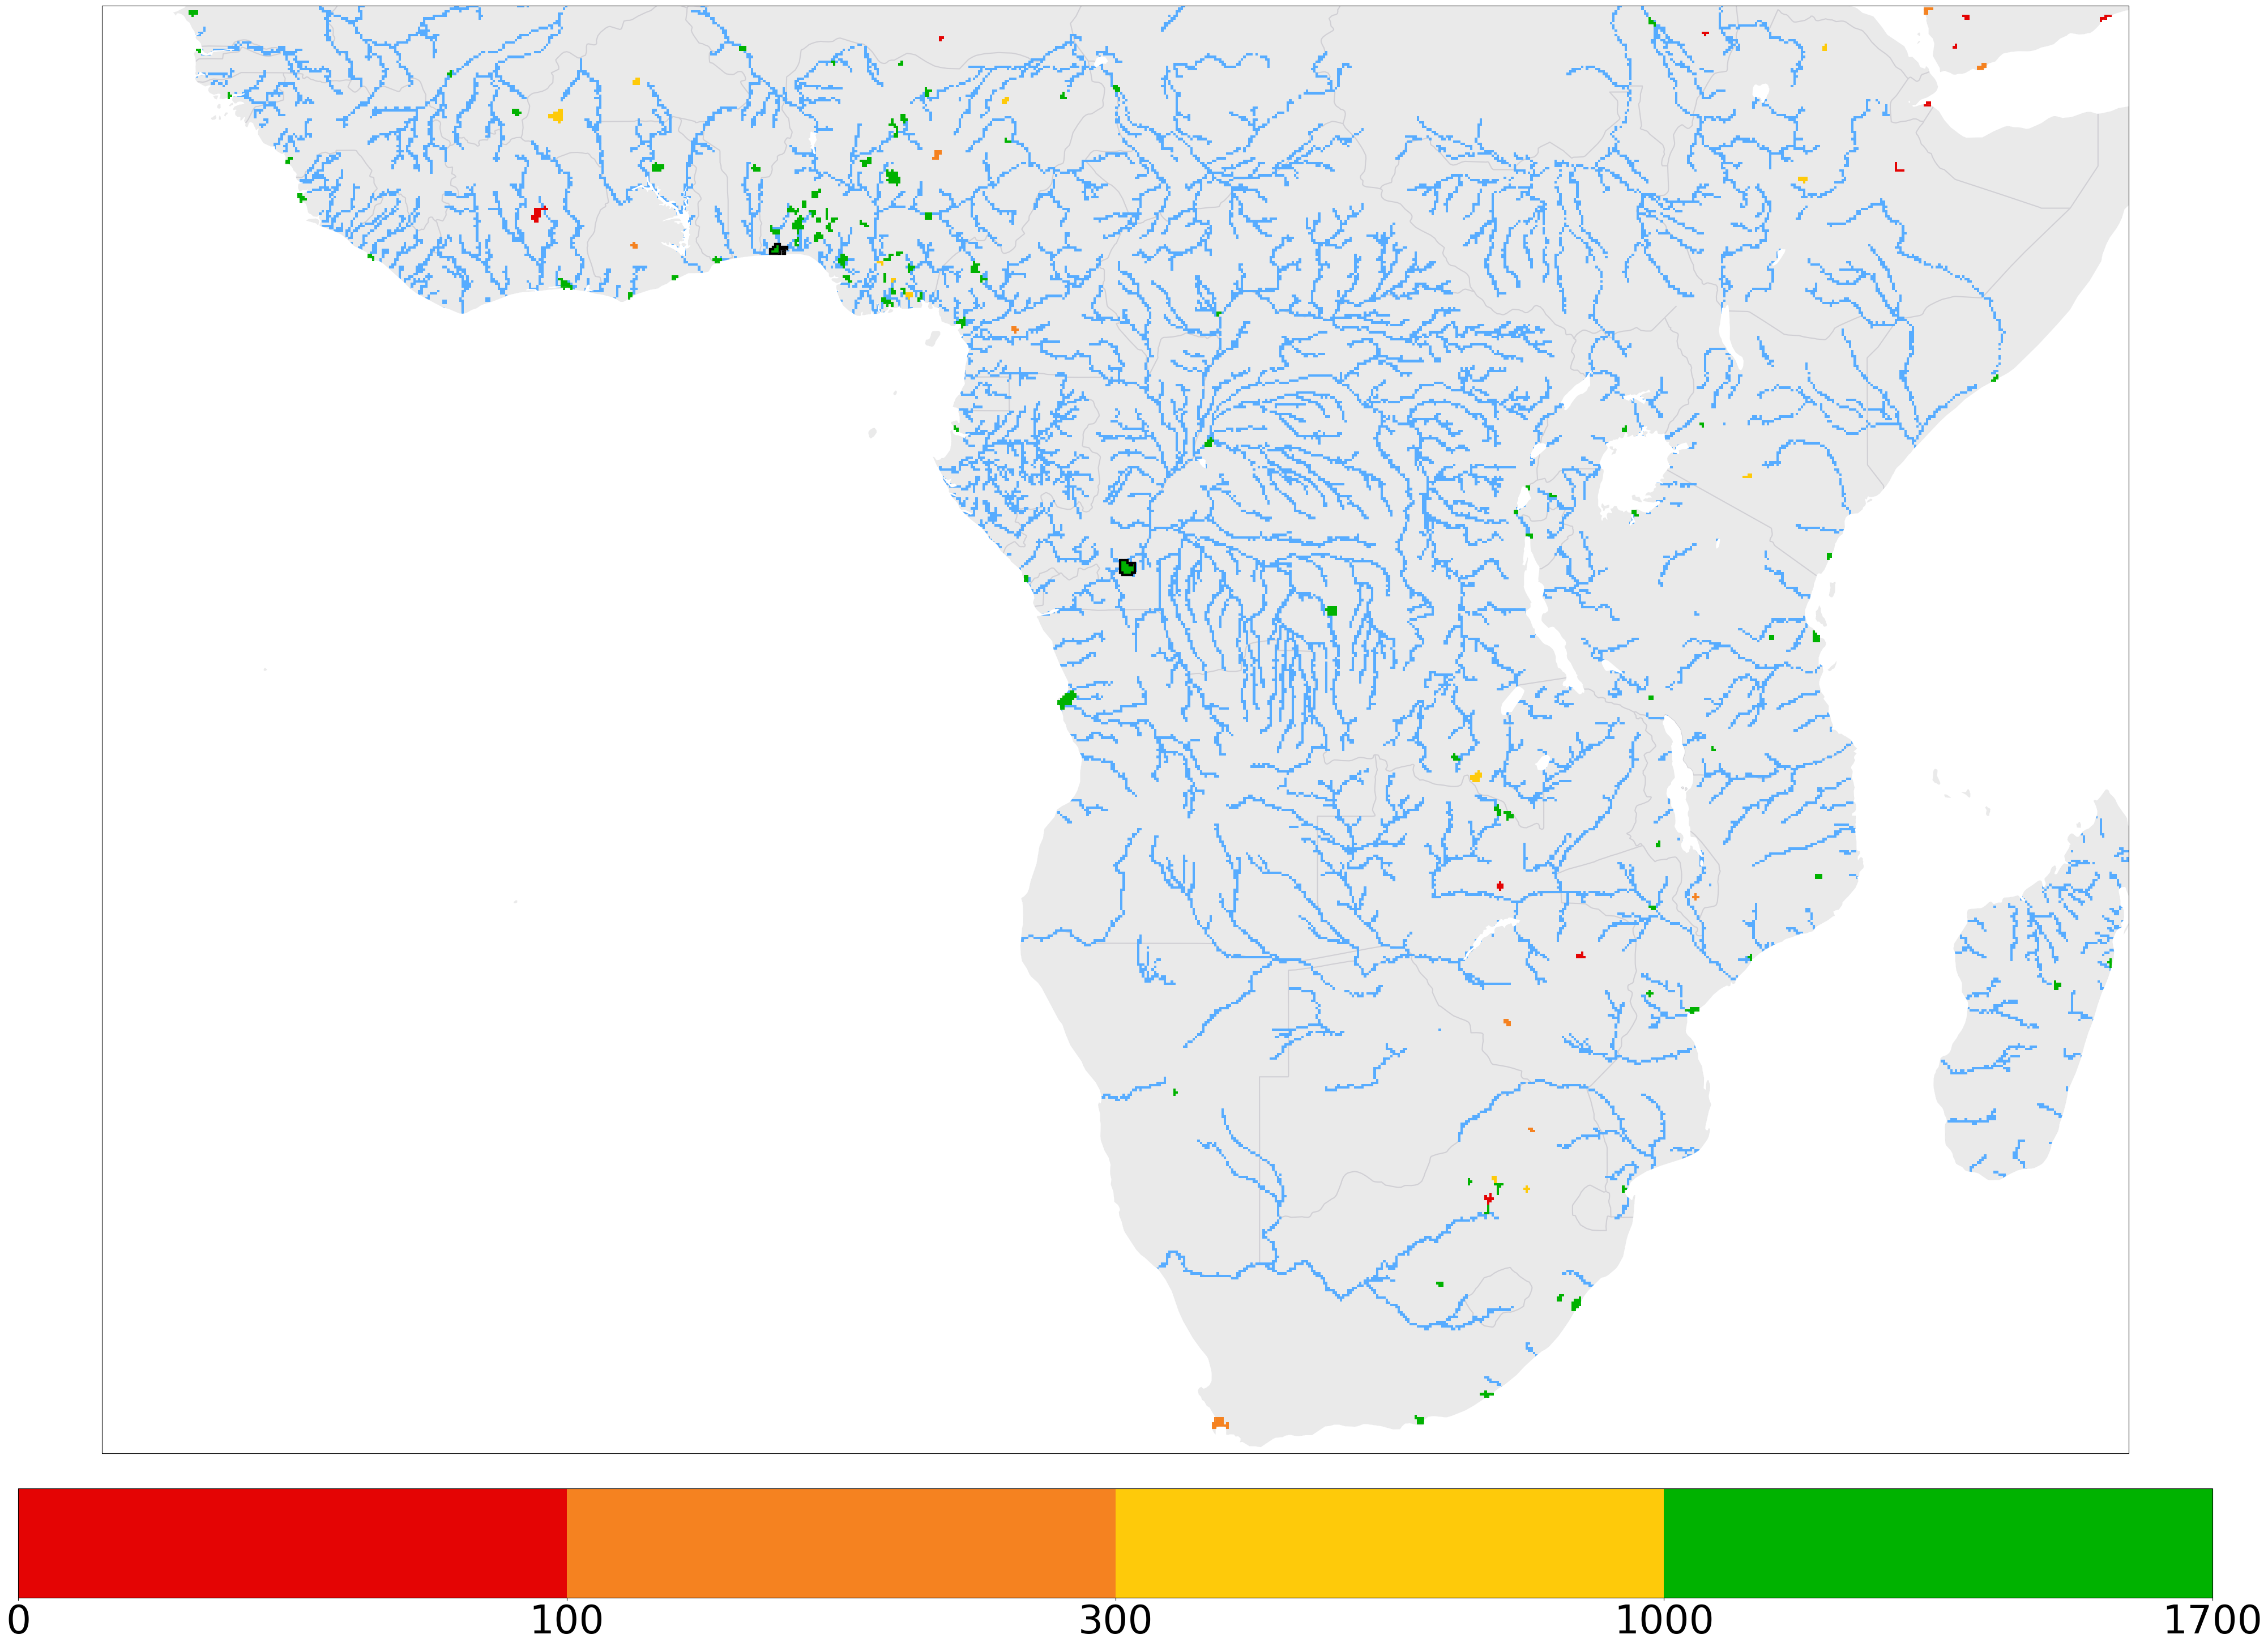

In [2]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import os
import matplotlib.colors as mcolors

def geography(left, right, bottom, top):
    #
    resolution = 12
    #
    upperindex = (90-top)*resolution
    lowerindex = (90-bottom)*resolution
    leftindex = (180+left)*resolution
    rightindex = (180+right)*resolution
    #
    rgnshape = (lowerindex-upperindex, rightindex-leftindex)
    #
    img_extent = (left, right, bottom, top)
    
    return upperindex, lowerindex, leftindex, rightindex, rgnshape, img_extent

def draw_mask_sotowaku_outer(extent, mask_cropped, ax=None, sotowaku_color='#dc143c', linewidth=5, padding=0.1, pop_thres=5e6):
    """
    zorder = 0: デフォルトの最背面(gridをzorder=0に設定)
    zorder = 1: 赤色の外枠(citymask)
    
    extent: (x_left, x_right, y_bottom, y_top)
    mask_cropped: マスクされた都市域の2D配列
    ax: プロットする軸
    sotowaku_color: 枠線の色
    linewidth: 枠線の太さ
    padding: 枠線を外側にシフトさせる量（度単位）
    """
    mask_cropped = np.ma.filled(mask_cropped, 0)

    # delta
    delta = 360/4320
    x_left = extent[0]
    y_top = extent[3]
    
    # outer
    upper_indices = []
    lower_indices = []
    left_indices = []
    right_indices = []
    rows, cols = mask_cropped.shape
    for i in range(rows-1):
        for j in range(cols-1):
            if mask_cropped[i, j] > pop_thres and mask_cropped[i, j] != 0:
                if i > 0 and mask_cropped[i-1, j] == 0:
                    upper_indices.append((i, j))
                if i < rows-1 and mask_cropped[i+1, j] == 0:
                    lower_indices.append((i, j))
                if j > 0 and mask_cropped[i, j-1] == 0:
                    left_indices.append((i, j))
                if j < cols-1 and mask_cropped[i, j+1] == 0:
                    right_indices.append((i, j))

    # extent
    projection = ccrs.PlateCarree()

    # city mask
    for up in upper_indices:
        x_index = x_left + delta*(up[1])
        y_index = y_top - delta*(up[0]) + padding * delta
        ax.plot([x_index, x_index+delta], [y_index, y_index], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # top
    for lo in lower_indices:
        x_index = x_left + delta*(lo[1])
        y_index = y_top - delta*(lo[0]+1) - padding * delta
        ax.plot([x_index, x_index+delta], [y_index, y_index], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # bottom
    for le in left_indices:
        x_index = x_left + delta*(le[1]) - padding * delta
        y_index = y_top - delta*(le[0]+1)
        ax.plot([x_index, x_index], [y_index, y_index+delta], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # left
    for ri in right_indices:
        x_index = x_left + delta*(ri[1]+1) + padding * delta
        y_index = y_top - delta*(ri[0]+1)
        ax.plot([x_index, x_index], [y_index, y_index+delta], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # right

    return ax

def toy_plot(left, right, bottom, top, linewidth=5, padding=0.1):
    h08dir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08'
    upperindex, lowerindex, leftindex, rightindex, rgnshape, img_extent = geography(left, right, bottom, top)
    
    # wsi/pre/population_m3year.ipynb
    population_path = f'{h08dir}/wsi/dat/population/population_threshold_world.npy'
    population = np.load(population_path)
    population_cropped = population[upperindex:lowerindex, leftindex:rightindex]
    
    # discharge
    threshold = 1*1e6*2500
    riv_path = f'{h08dir}/wsi/dat/riv_out_/W5E5LR__00000000.gl5'
    rivout = np.fromfile(riv_path, dtype='float32').reshape(2160, 4320)
    rivout_cropped = rivout[upperindex:lowerindex, leftindex:rightindex] * 60 * 60 * 24 * 365 / 1000
    rivout_masked = np.ma.masked_where(rivout_cropped==0, rivout_cropped)
    rivout_thres = np.ma.masked_where(rivout_masked<threshold, rivout_masked)
    
    # wsi/pre/MPCY_citylonlat_citygrid.ipynb
    grid_path = f'{h08dir}/wsi/dat/cmy/world_citygrid_100km_abandon.npy'
    citygrid = np.load(grid_path)
    citygrid_masked = np.ma.masked_where(citygrid==0, citygrid)
    region = citygrid_masked[upperindex:lowerindex, leftindex:rightindex]
    region_masked = np.ma.masked_where(region==0, region)
    
    bounds = [0, 100, 300, 1000, 1700]
    #cmap = mcolors.ListedColormap(['#e40404', '#f58220', '#feca0a', '#89989c'])
    #cmap = mcolors.ListedColormap(['#e40404', '#f58220', '#feca0a', '#f0fff0'])
    cmap = mcolors.ListedColormap(['#e40404', '#f58220', '#feca0a', '#00b200'])
    norm = mcolors.BoundaryNorm(bounds, cmap.N)
    
    plt.rcParams["font.size"] = 50
    projection = ccrs.PlateCarree()
    fig, ax = plt.subplots(figsize=(50,40), subplot_kw={'projection': projection})

    #river_cmap = mcolors.ListedColormap(['#60c9f8'])
    #river_cmap = mcolors.ListedColormap(['#3eb1c8'])
    river_cmap = mcolors.ListedColormap(['#57acff'])
    imr = ax.imshow(rivout_thres, 
                    extent=img_extent,
                    cmap=river_cmap,
                    transform=projection,
                    zorder=-2
                   )
    
    imd = ax.imshow(region_masked, 
                  cmap= cmap,
                  norm = norm,
                  extent=img_extent,
                  transform=projection, 
                 )
    
    ax.add_feature(cfeature.LAND, edgecolor='none', facecolor='#eaeaea', zorder=-3)
    ax.add_feature(cfeature.OCEAN, edgecolor='none', facecolor='#ffffff')
    ax.add_feature(cfeature.LAKES, edgecolor='none', facecolor='#ffffff', zorder=-1)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.1,edgecolor='#d0cfd4')
    ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=1.5, edgecolor='#d0cfd4', zorder=-3)
    ax.gridlines(visible=False)
    cbar = fig.colorbar(imd, ax=ax, orientation='horizontal', pad=0.02)
    draw_mask_sotowaku_outer(img_extent, population_cropped, ax=ax, sotowaku_color='black', linewidth=linewidth, padding=padding, pop_thres=5e6)
    plt.show()

linewidth = 3
padding = 0.0
toy_plot(-10, 39, 29, 63, linewidth=linewidth, padding=padding)
toy_plot(-125, -65, 15, 50, linewidth=linewidth, padding=padding)
toy_plot(35 ,90, 5, 35, linewidth=linewidth, padding=padding)
toy_plot(85, 145, 12, 48, linewidth=linewidth, padding=padding)
toy_plot(-90, -30, -39, 10, linewidth=linewidth, padding=padding)
toy_plot(-20, 50, -35, 15, linewidth=linewidth, padding=padding)

In [43]:
# Crouch 2021 AQUA
# minimum  92 L/capita/day = 33.58 m3/capita/year
# maximum 314 L/capita/day = 114.61 m3/capita/year

# AQUASTAT
# population total of gpwv4.11 = 6,929,592,300
# 4300km3 / 6.929 billion      = 620.58 m3/capita/yeaer    = 1700 L/capita/year
# municipal(11%)               = 68.260 m3/capita/year     = 187.01 L/capita/year
# industry (19%)               = 117.91 m3/capita/year     = 323.04 L/capita/year
# agriculture (70%)            = 434.41 m3/capita/year     = 1190.1 L/capita/year

# Falkenmark 1989
# 1000 m3/capita/year
# municipal (11%)   = 110 m3/capita/yaer = 300 L/capita/day
# industry  (19%)   = 190 m3/capita/year = 518 L/capita/day
# agriculture (70%) = 700 m3/capita/year = 1911 L/capita/day

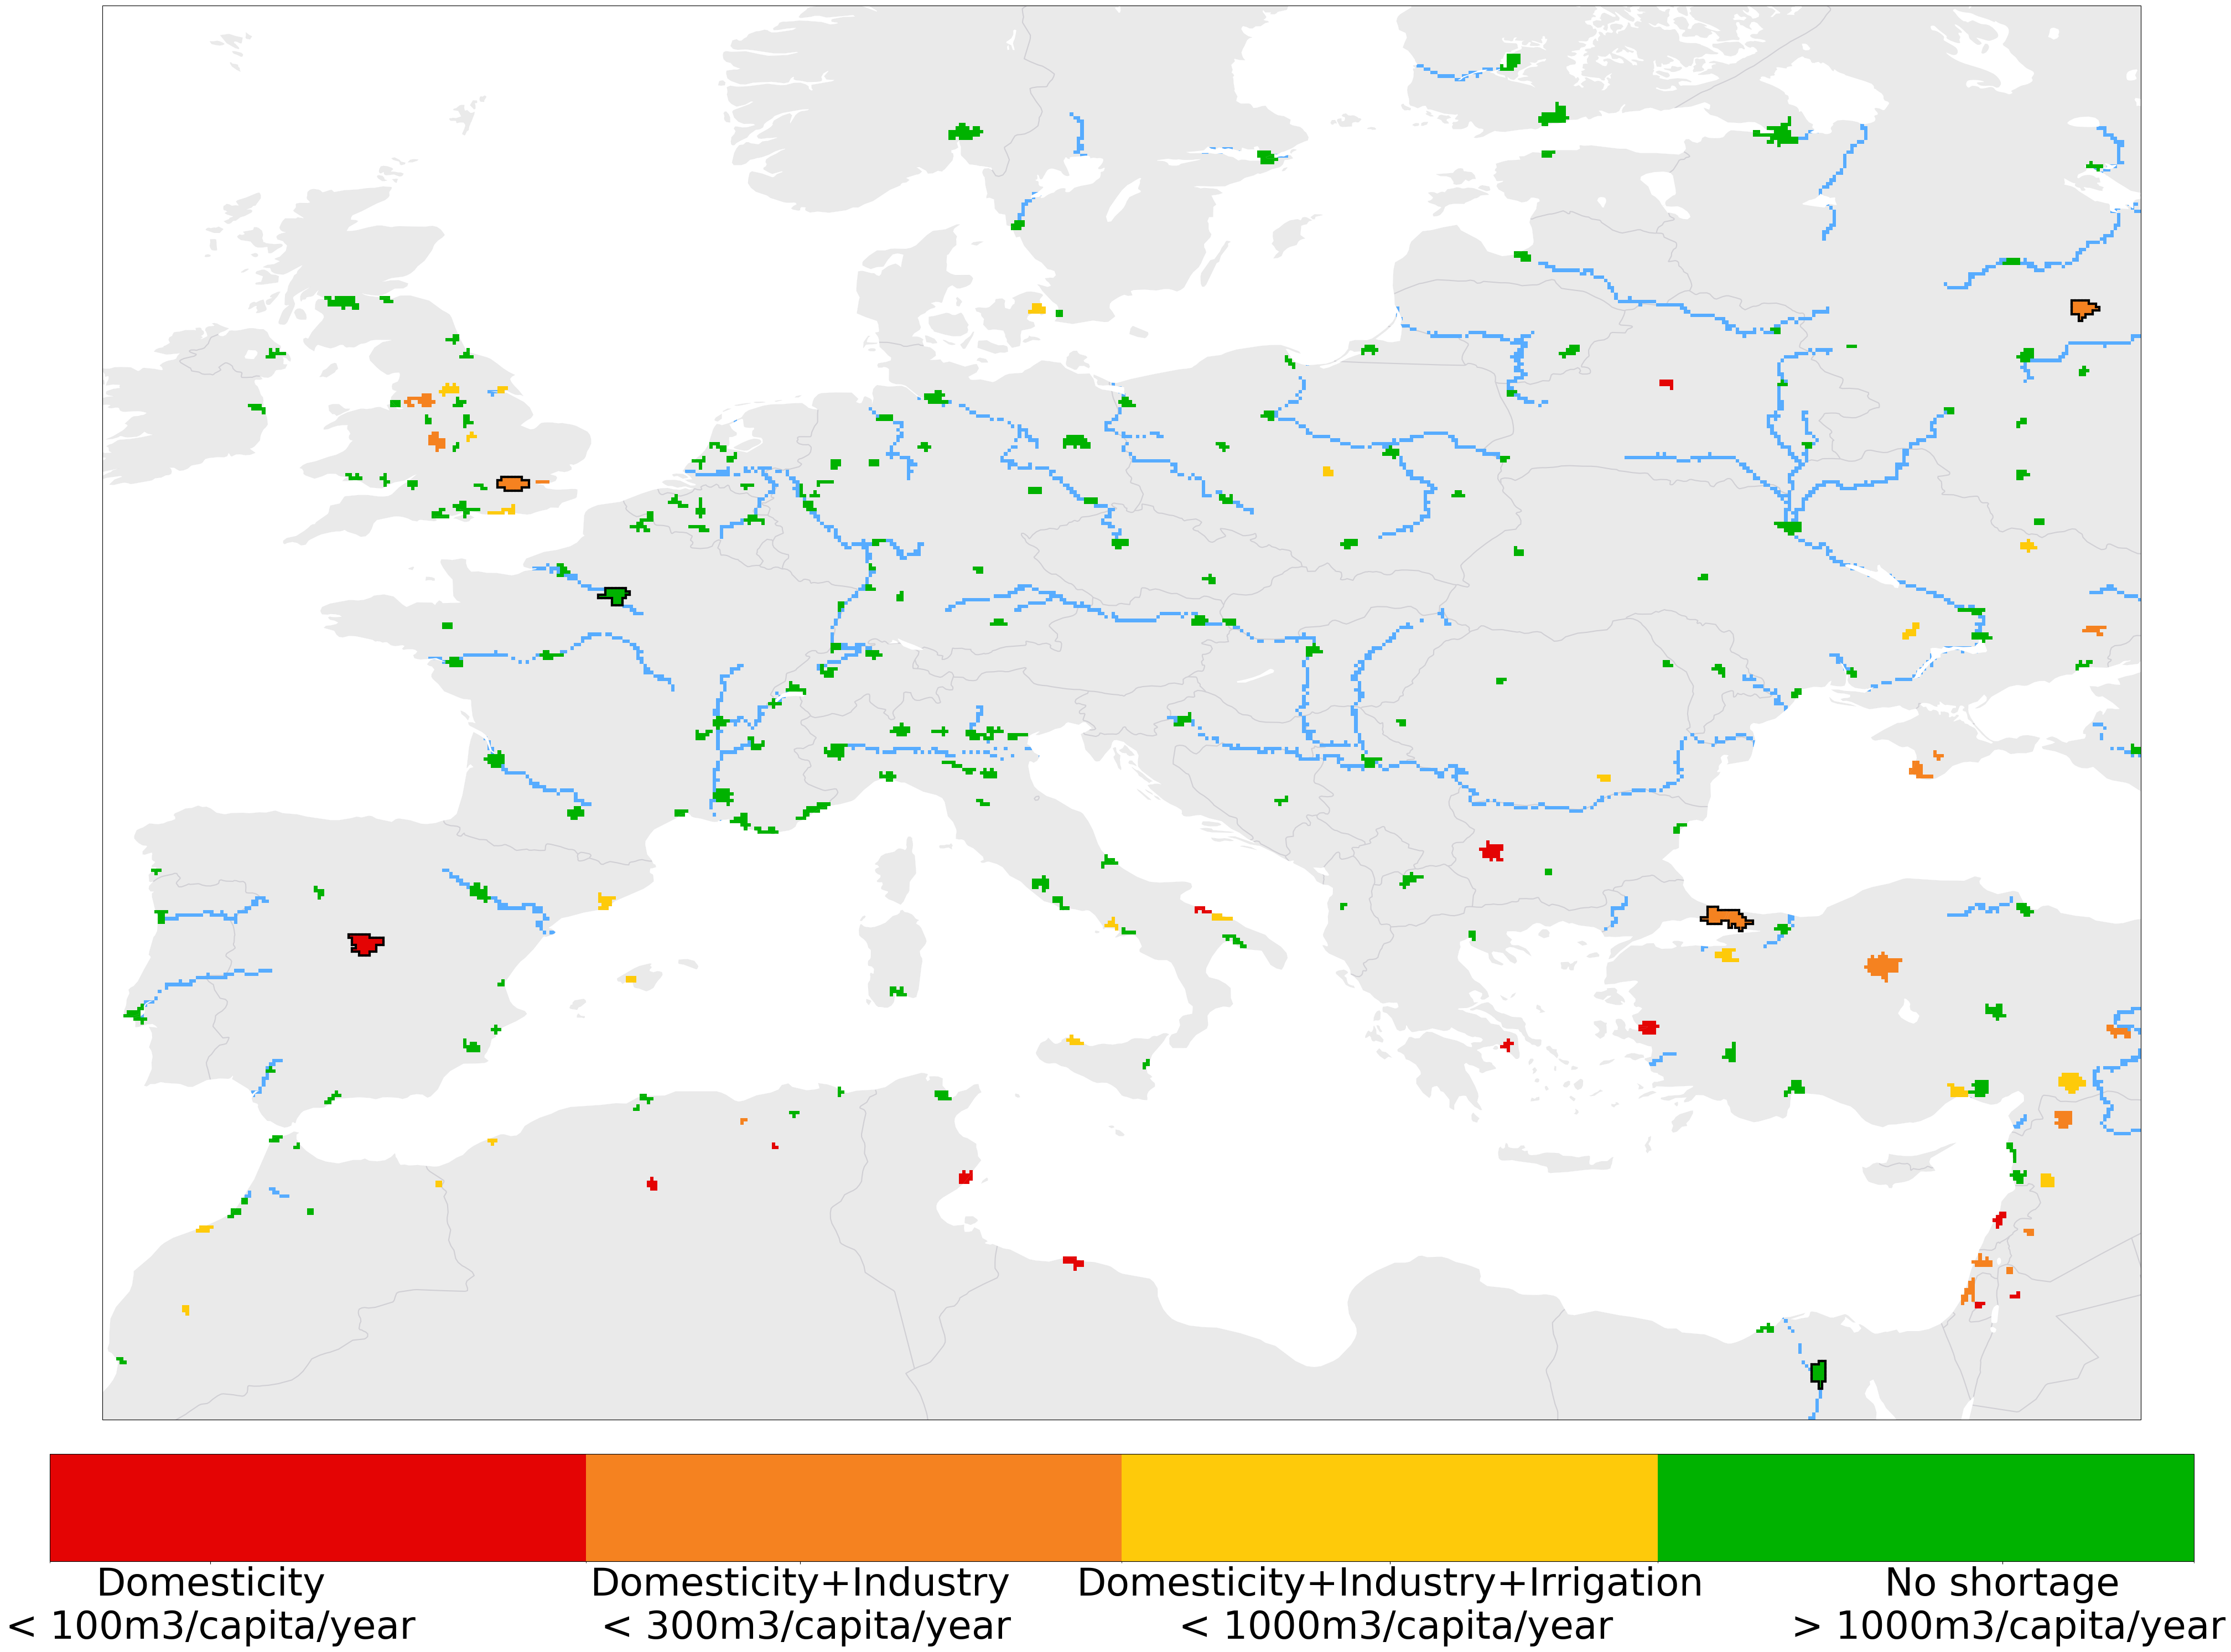

In [25]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import os
import matplotlib.colors as mcolors

#各都市が利用する主河道のみを記述する方法

def geography(left, right, bottom, top):
    #
    resolution = 12
    #
    upperindex = (90-top)*resolution
    lowerindex = (90-bottom)*resolution
    leftindex = (180+left)*resolution
    rightindex = (180+right)*resolution
    #
    rgnshape = (lowerindex-upperindex, rightindex-leftindex)
    #
    img_extent = (left, right, bottom, top)
    
    return upperindex, lowerindex, leftindex, rightindex, rgnshape, img_extent

def draw_mask_sotowaku_outer(extent, mask_cropped, ax=None, sotowaku_color='#dc143c', linewidth=5, padding=0.1, pop_thres=5e6):
    """
    zorder = 0: デフォルトの最背面(gridをzorder=0に設定)
    zorder = 1: 赤色の外枠(citymask)
    
    extent: (x_left, x_right, y_bottom, y_top)
    mask_cropped: マスクされた都市域の2D配列
    ax: プロットする軸
    sotowaku_color: 枠線の色
    linewidth: 枠線の太さ
    padding: 枠線を外側にシフトさせる量（度単位）
    """
    mask_cropped = np.ma.filled(mask_cropped, 0)

    # delta
    delta = 360/4320
    x_left = extent[0]
    y_top = extent[3]
    
    # outer
    upper_indices = []
    lower_indices = []
    left_indices = []
    right_indices = []
    rows, cols = mask_cropped.shape
    for i in range(rows-1):
        for j in range(cols-1):
            if mask_cropped[i, j] > pop_thres and mask_cropped[i, j] != 0:
                if i > 0 and mask_cropped[i-1, j] == 0:
                    upper_indices.append((i, j))
                if i < rows-1 and mask_cropped[i+1, j] == 0:
                    lower_indices.append((i, j))
                if j > 0 and mask_cropped[i, j-1] == 0:
                    left_indices.append((i, j))
                if j < cols-1 and mask_cropped[i, j+1] == 0:
                    right_indices.append((i, j))

    # extent
    projection = ccrs.PlateCarree()

    # city mask
    for up in upper_indices:
        x_index = x_left + delta*(up[1])
        y_index = y_top - delta*(up[0]) + padding * delta
        ax.plot([x_index, x_index+delta], [y_index, y_index], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # top
    for lo in lower_indices:
        x_index = x_left + delta*(lo[1])
        y_index = y_top - delta*(lo[0]+1) - padding * delta
        ax.plot([x_index, x_index+delta], [y_index, y_index], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # bottom
    for le in left_indices:
        x_index = x_left + delta*(le[1]) - padding * delta
        y_index = y_top - delta*(le[0]+1)
        ax.plot([x_index, x_index], [y_index, y_index+delta], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # left
    for ri in right_indices:
        x_index = x_left + delta*(ri[1]+1) + padding * delta
        y_index = y_top - delta*(ri[0]+1)
        ax.plot([x_index, x_index], [y_index, y_index+delta], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # right

    return ax

def cbarticker(left, right, bottom, top, linewidth=5, padding=0.1):
    h08dir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08'
    upperindex, lowerindex, leftindex, rightindex, rgnshape, img_extent = geography(left, right, bottom, top)
    
    # wsi/pre/population_m3year.ipynb
    population_path = f'{h08dir}/wsi/dat/population/population_threshold_world.npy'
    population = np.load(population_path)
    population_cropped = population[upperindex:lowerindex, leftindex:rightindex]
    
    # wsi/pre/availability_m3year.ipynb
    availability_path = f'{h08dir}/wsi/dat/availablewater/availablewater_threshold_world.npy'
    availability = np.load(availability_path)
    availability_cropped = availability[upperindex:lowerindex, leftindex:rightindex]

    # rive path array
    riv_path_array_path = f'{h08dir}/wsi/dat/riv_path/riv_path_array.gl5'
    riv_path_array = np.fromfile(riv_path_array_path, dtype='float32').reshape(2160, 4320)

    # discharge
    pop_thres=5e6
    threshold = 5*1e6*1000
    riv_path = f'{h08dir}/wsi/dat/riv_out_/W5E5LR__00000000.gl5'
    rivout = np.fromfile(riv_path, dtype='float32').reshape(2160, 4320)
    rivout_tmp = np.ma.masked_where(riv_path_array==0, rivout)
    rivout_cropped = rivout_tmp[upperindex:lowerindex, leftindex:rightindex] * 60 * 60 * 24 * 365 / 1000
    rivout_masked = np.ma.masked_where(rivout_cropped==0, rivout_cropped)
    rivout_thres = np.ma.masked_where(rivout_masked<threshold, rivout_masked)
    
    # wsi/pre/MPCY_citylonlat_citygrid.ipynb
    grid_path = f'{h08dir}/wsi/dat/cmy/world_citygrid_100km_abandon.npy'
    citygrid = np.load(grid_path)
    citygrid_masked = np.ma.masked_where(citygrid==0, citygrid)
    region = citygrid_masked[upperindex:lowerindex, leftindex:rightindex]
    region_masked = np.ma.masked_where(region==0, region)
    
    bounds = [0, 100, 300, 1000, 1700]
    cmap = mcolors.ListedColormap(['#e40404', '#f58220', '#feca0a', '#00b200'])
    norm = mcolors.BoundaryNorm(bounds, cmap.N)
    
    plt.rcParams["font.size"] = 50
    projection = ccrs.PlateCarree()
    fig, ax = plt.subplots(figsize=(50,40), subplot_kw={'projection': projection})

    river_cmap = mcolors.ListedColormap(['#57acff'])
    imr = ax.imshow(rivout_thres, 
                    extent=img_extent,
                    cmap=river_cmap,
                    transform=projection,
                    zorder=-2
                   )
    
    imd = ax.imshow(region_masked, 
                  cmap= cmap,
                  norm = norm,
                  extent=img_extent,
                  transform=projection, 
                 )
    
    ax.add_feature(cfeature.LAND, edgecolor='none', facecolor='#eaeaea', zorder=-3)
    ax.add_feature(cfeature.OCEAN, edgecolor='none', facecolor='#ffffff')
    ax.add_feature(cfeature.LAKES, edgecolor='none', facecolor='#ffffff', zorder=-1)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.1,edgecolor='#d0cfd4')
    ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=1.5, edgecolor='#d0cfd4', zorder=-3)
    ax.gridlines(visible=False)
    cbar = fig.colorbar(imd, ax=ax, orientation='horizontal', pad=0.02)
    cbar.set_ticks([30, 180, 650, 1450])  # Ticksの設定
    cbar.set_ticklabels(['Domesticity\n< 100m3/capita/year', 
                         'Domesticity+Industry\n < 300m3/capita/year', 
                         'Domesticity+Industry+Irrigation\n < 1000m3/capita/year', 
                         'No shortage\n > 1000m3/capita/year'])  # Tick labelsの設定
    draw_mask_sotowaku_outer(img_extent, population_cropped, ax=ax, sotowaku_color='black', linewidth=linewidth, padding=padding, pop_thres=pop_thres)
    plt.show()

linewidth = 3
padding = 0.0
cbarticker(-10, 39, 29, 63, linewidth=linewidth, padding=padding)
#cbarticker(-125, -65, 15, 50, linewidth=linewidth, padding=padding)
#cbarticker(35 ,90, 5, 35, linewidth=linewidth, padding=padding)
#cbarticker(85, 145, 12, 48, linewidth=linewidth, padding=padding)
#cbarticker(-90, -30, -39, 10, linewidth=linewidth, padding=padding)
#cbarticker(-20, 50, -35, 15, linewidth=linewidth, padding=padding)

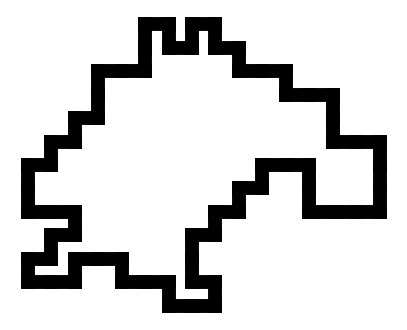

In [22]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import os
import matplotlib.colors as mcolors

#各都市が利用する主河道のみを記述する方法

def geography(left, right, bottom, top):
    #
    resolution = 12
    #
    upperindex = (90-top)*resolution
    lowerindex = (90-bottom)*resolution
    leftindex = (180+left)*resolution
    rightindex = (180+right)*resolution
    #
    rgnshape = (lowerindex-upperindex, rightindex-leftindex)
    #
    img_extent = (left, right, bottom, top)
    
    return upperindex, lowerindex, leftindex, rightindex, rgnshape, img_extent

def draw_mask_sotowaku_outer(extent, mask_cropped, ax=None, sotowaku_color='#dc143c', linewidth=5, padding=0.1, pop_thres=5e6):
    """
    zorder = 0: デフォルトの最背面(gridをzorder=0に設定)
    zorder = 1: 赤色の外枠(citymask)
    
    extent: (x_left, x_right, y_bottom, y_top)
    mask_cropped: マスクされた都市域の2D配列
    ax: プロットする軸
    sotowaku_color: 枠線の色
    linewidth: 枠線の太さ
    padding: 枠線を外側にシフトさせる量（度単位）
    """
    mask_cropped = np.ma.filled(mask_cropped, 0)

    # delta
    delta = 360/4320
    x_left = extent[0]
    y_top = extent[3]
    
    # outer
    upper_indices = []
    lower_indices = []
    left_indices = []
    right_indices = []
    rows, cols = mask_cropped.shape
    for i in range(rows-1):
        for j in range(cols-1):
            if mask_cropped[i, j] > pop_thres and mask_cropped[i, j] != 0:
                if i > 0 and mask_cropped[i-1, j] == 0:
                    upper_indices.append((i, j))
                if i < rows-1 and mask_cropped[i+1, j] == 0:
                    lower_indices.append((i, j))
                if j > 0 and mask_cropped[i, j-1] == 0:
                    left_indices.append((i, j))
                if j < cols-1 and mask_cropped[i, j+1] == 0:
                    right_indices.append((i, j))

    # extent
    projection = ccrs.PlateCarree()

    # city mask
    for up in upper_indices:
        x_index = x_left + delta*(up[1])
        y_index = y_top - delta*(up[0]) + padding * delta
        ax.plot([x_index, x_index+delta], [y_index, y_index], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # top
    for lo in lower_indices:
        x_index = x_left + delta*(lo[1])
        y_index = y_top - delta*(lo[0]+1) - padding * delta
        ax.plot([x_index, x_index+delta], [y_index, y_index], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # bottom
    for le in left_indices:
        x_index = x_left + delta*(le[1]) - padding * delta
        y_index = y_top - delta*(le[0]+1)
        ax.plot([x_index, x_index], [y_index, y_index+delta], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # left
    for ri in right_indices:
        x_index = x_left + delta*(ri[1]+1) + padding * delta
        y_index = y_top - delta*(ri[0]+1)
        ax.plot([x_index, x_index], [y_index, y_index+delta], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # right

    return ax

def icon(left, right, bottom, top, linewidth=5, padding=0.1):
    h08dir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08'
    upperindex, lowerindex, leftindex, rightindex, rgnshape, img_extent = geography(left, right, bottom, top)
    
    # wsi/pre/population_m3year.ipynb
    population_path = f'{h08dir}/wsi/dat/population/population_threshold_world.npy'
    population = np.load(population_path)
    population_cropped = population[upperindex:lowerindex, leftindex:rightindex]
    
    # wsi/pre/availability_m3year.ipynb
    availability_path = f'{h08dir}/wsi/dat/availablewater/availablewater_threshold_world.npy'
    availability = np.load(availability_path)
    availability_cropped = availability[upperindex:lowerindex, leftindex:rightindex]

    # rive path array
    riv_path_array_path = f'{h08dir}/wsi/dat/riv_path/riv_path_array.gl5'
    riv_path_array = np.fromfile(riv_path_array_path, dtype='float32').reshape(2160, 4320)

    # discharge
    pop_thres=5e6
    threshold = 5*1e6*1000
    riv_path = f'{h08dir}/wsi/dat/riv_out_/W5E5LR__00000000.gl5'
    rivout = np.fromfile(riv_path, dtype='float32').reshape(2160, 4320)
    rivout_tmp = np.ma.masked_where(riv_path_array==0, rivout)
    rivout_cropped = rivout_tmp[upperindex:lowerindex, leftindex:rightindex] * 60 * 60 * 24 * 365 / 1000
    rivout_masked = np.ma.masked_where(rivout_cropped==0, rivout_cropped)
    rivout_thres = np.ma.masked_where(rivout_masked<threshold, rivout_masked)
    
    # wsi/pre/MPCY_citylonlat_citygrid.ipynb
    grid_path = f'{h08dir}/wsi/dat/cmy/world_citygrid.npy'
    citygrid = np.load(grid_path)
    citygrid_masked = np.ma.masked_where(citygrid==0, citygrid)
    region = citygrid_masked[upperindex:lowerindex, leftindex:rightindex]
    region_masked = np.ma.masked_where(region==0, region)
    
    bounds = [0, 100, 300, 1000, 1700]
    cmap = mcolors.ListedColormap(['#e40404', '#f58220', '#feca0a', '#00b200'])
    norm = mcolors.BoundaryNorm(bounds, cmap.N)
    
    plt.rcParams["font.size"] = 50
    projection = ccrs.PlateCarree()
    fig, ax = plt.subplots(figsize=(5,5), subplot_kw={'projection': projection})

    river_cmap = mcolors.ListedColormap(['#57acff'])
    
    ax.gridlines(visible=False)
    ax.spines['geo'].set_visible(False)
    draw_mask_sotowaku_outer(img_extent, population_cropped, ax=ax, sotowaku_color='black', linewidth=linewidth, padding=padding, pop_thres=pop_thres)
    plt.show()

linewidth = 10
padding = 0.0
icon(138, 141, 34, 38, linewidth=linewidth, padding=padding)

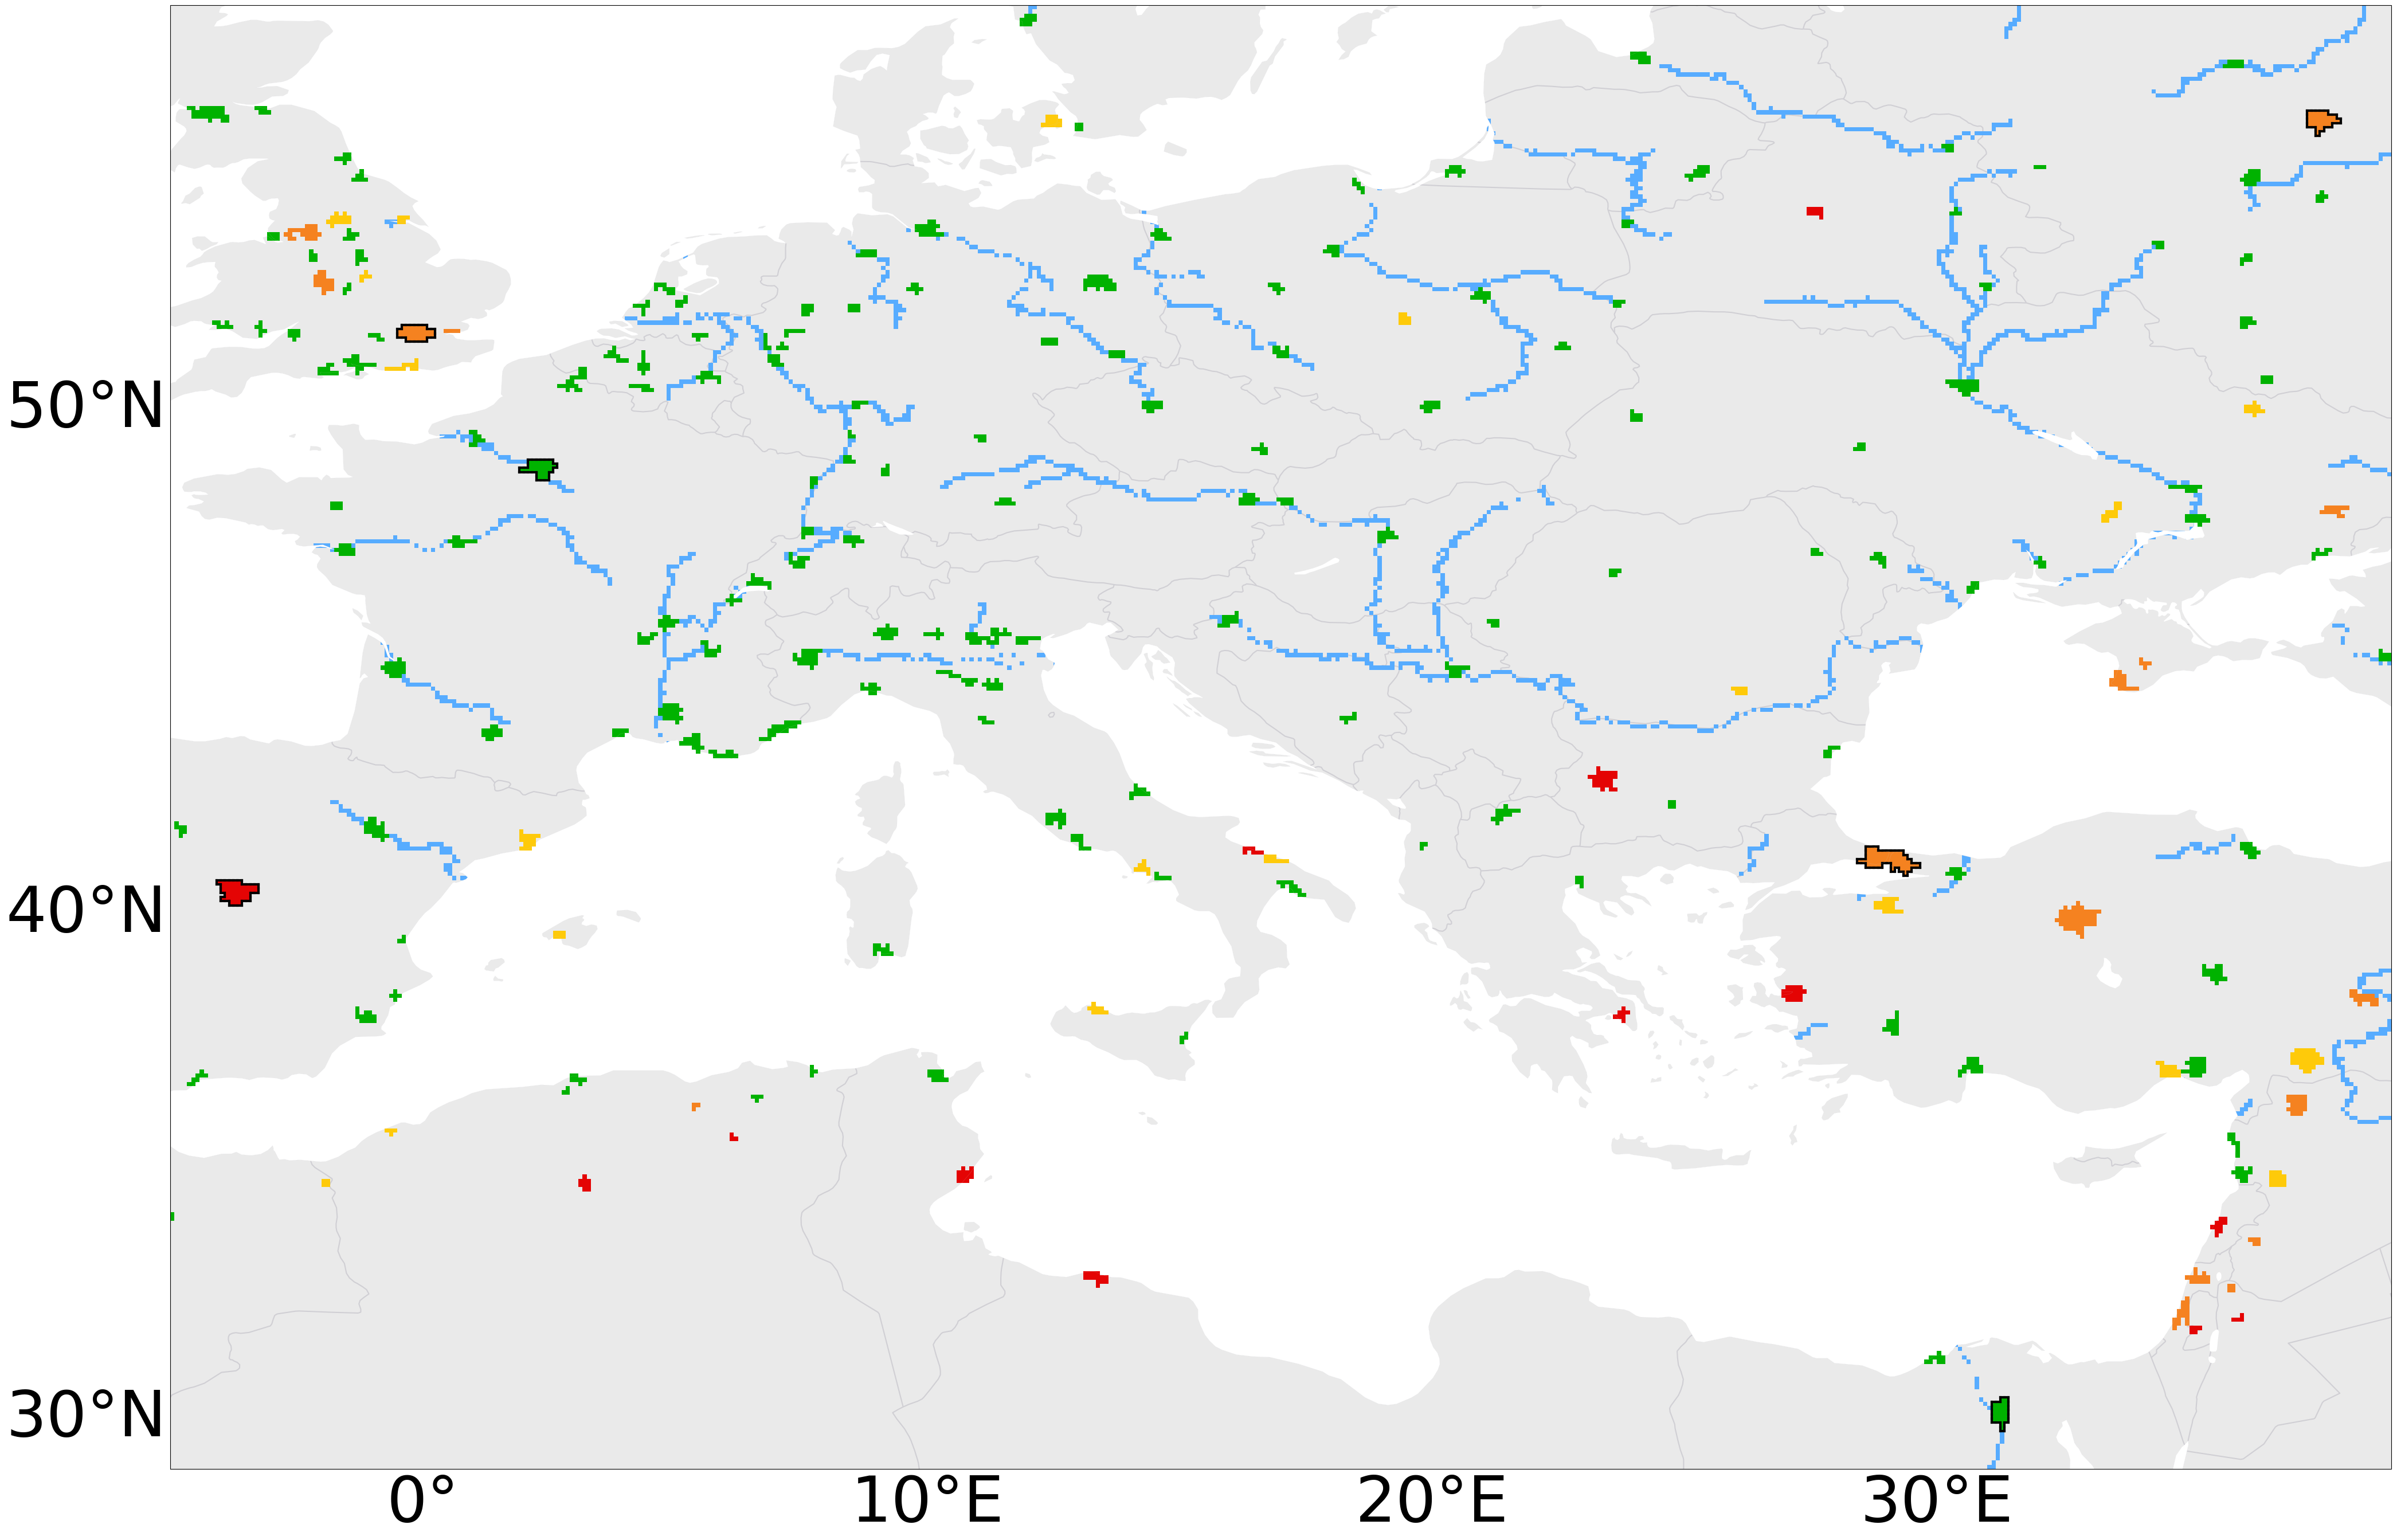

In [24]:
# paper review

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker

#各都市が利用する主河道のみを記述する方法

def geography(left, right, bottom, top):
    #
    resolution = 12
    #
    upperindex = (90-top)*resolution
    lowerindex = (90-bottom)*resolution
    leftindex = (180+left)*resolution
    rightindex = (180+right)*resolution
    #
    rgnshape = (lowerindex-upperindex, rightindex-leftindex)
    #
    img_extent = (left, right, bottom, top)
    
    return upperindex, lowerindex, leftindex, rightindex, rgnshape, img_extent

def draw_mask_sotowaku_outer(extent, mask_cropped, ax=None, sotowaku_color='#dc143c', linewidth=5, padding=0.1, pop_thres=5e6):
    """
    zorder = 0: デフォルトの最背面(gridをzorder=0に設定)
    zorder = 1: 赤色の外枠(citymask)
    
    extent: (x_left, x_right, y_bottom, y_top)
    mask_cropped: マスクされた都市域の2D配列
    ax: プロットする軸
    sotowaku_color: 枠線の色
    linewidth: 枠線の太さ
    padding: 枠線を外側にシフトさせる量（度単位）
    """
    mask_cropped = np.ma.filled(mask_cropped, 0)

    # delta
    delta = 360/4320
    x_left = extent[0]
    y_top = extent[3]
    
    # outer
    upper_indices = []
    lower_indices = []
    left_indices = []
    right_indices = []
    rows, cols = mask_cropped.shape
    for i in range(rows-1):
        for j in range(cols-1):
            if mask_cropped[i, j] > pop_thres and mask_cropped[i, j] != 0:
                if i > 0 and mask_cropped[i-1, j] == 0:
                    upper_indices.append((i, j))
                if i < rows-1 and mask_cropped[i+1, j] == 0:
                    lower_indices.append((i, j))
                if j > 0 and mask_cropped[i, j-1] == 0:
                    left_indices.append((i, j))
                if j < cols-1 and mask_cropped[i, j+1] == 0:
                    right_indices.append((i, j))

    # extent
    projection = ccrs.PlateCarree()

    # city mask
    for up in upper_indices:
        x_index = x_left + delta*(up[1])
        y_index = y_top - delta*(up[0]) + padding * delta
        ax.plot([x_index, x_index+delta], [y_index, y_index], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # top
    for lo in lower_indices:
        x_index = x_left + delta*(lo[1])
        y_index = y_top - delta*(lo[0]+1) - padding * delta
        ax.plot([x_index, x_index+delta], [y_index, y_index], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # bottom
    for le in left_indices:
        x_index = x_left + delta*(le[1]) - padding * delta
        y_index = y_top - delta*(le[0]+1)
        ax.plot([x_index, x_index], [y_index, y_index+delta], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # left
    for ri in right_indices:
        x_index = x_left + delta*(ri[1]+1) + padding * delta
        y_index = y_top - delta*(ri[0]+1)
        ax.plot([x_index, x_index], [y_index, y_index+delta], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # right

    return ax

def paper_plot(left, right, bottom, top, linewidth=5, padding=0.1):
    # init 
    pop_thres=5e6
    threshold = 5*1e6*1000

    # path
    h08dir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08'
    upperindex, lowerindex, leftindex, rightindex, rgnshape, img_extent = geography(left, right, bottom, top)
    
    # wsi/pre/population_m3year.ipynb
    population_path = f'{h08dir}/wsi/dat/population/population_threshold_world.npy'
    population = np.load(population_path)
    population_cropped = population[upperindex:lowerindex, leftindex:rightindex]
    
    # wsi/pre/availability_m3year.ipynb
    availability_path = f'{h08dir}/wsi/dat/availablewater/availablewater_threshold_world.npy'
    availability = np.load(availability_path)
    availability_cropped = availability[upperindex:lowerindex, leftindex:rightindex]

    # wsi/pst/MPCY_background.ipynb
    riv_path_array_path = f'{h08dir}/wsi/dat/riv_path/riv_path_array.gl5'
    riv_path_array = np.fromfile(riv_path_array_path, dtype='float32').reshape(2160, 4320)
    
    # wsi/pre/MPCY_citylonlat_citygrid.ipynb
    grid_path = f'{h08dir}/wsi/dat/cmy/world_citygrid_100km_abandon.npy'
    citygrid = np.load(grid_path)
    citygrid_masked = np.ma.masked_where(citygrid==0, citygrid)
    region = citygrid_masked[upperindex:lowerindex, leftindex:rightindex]
    region_masked = np.ma.masked_where(region==0, region)

    # discharge
    riv_path = f'{h08dir}/wsi/dat/riv_out_/W5E5LR__00000000.gl5'
    rivout = np.fromfile(riv_path, dtype='float32').reshape(2160, 4320)
    rivout_tmp = np.ma.masked_where(riv_path_array==0, rivout)
    rivout_cropped = rivout_tmp[upperindex:lowerindex, leftindex:rightindex] * 60 * 60 * 24 * 365 / 1000
    rivout_masked = np.ma.masked_where(rivout_cropped==0, rivout_cropped)
    rivout_thres = np.ma.masked_where(rivout_masked<threshold, rivout_masked)
    
    bounds = [0, 100, 300, 1000, 1700]
    cmap = mcolors.ListedColormap(['#e40404', '#f58220', '#feca0a', '#00b200'])
    norm = mcolors.BoundaryNorm(bounds, cmap.N)
    
    plt.rcParams["font.size"] = 50
    projection = ccrs.PlateCarree()
    fig, ax = plt.subplots(figsize=(50,40), subplot_kw={'projection': projection})

    river_cmap = mcolors.ListedColormap(['#57acff'])
    imr = ax.imshow(rivout_thres, 
                    extent=img_extent,
                    cmap=river_cmap,
                    transform=projection,
                    zorder=-2
                   )
    
    imd = ax.imshow(region_masked, 
                  cmap= cmap,
                  norm = norm,
                  extent=img_extent,
                  transform=projection, 
                 )
    
    ax.add_feature(cfeature.LAND, edgecolor='none', facecolor='#eaeaea', zorder=-3)
    ax.add_feature(cfeature.OCEAN, edgecolor='none', facecolor='#ffffff')
    ax.add_feature(cfeature.LAKES, edgecolor='none', facecolor='#ffffff', zorder=-1)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.1,edgecolor='#d0cfd4')
    ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=1.5, edgecolor='#d0cfd4', zorder=-3)
    
    gl = ax.gridlines(draw_labels=True, zorder=2, color='gray', alpha=0.5, linestyle='--')
    gl.xlocator = mticker.FixedLocator(np.arange(round(left/10)*10, right, 10))
    gl.ylocator = mticker.FixedLocator(np.arange(round(bottom/10)*10, top, 10))
    gl.top_labels = False
    gl.right_labels = False
    gl.bottom_labels = True
    gl.left_labels = True
    gl.xlines = False
    gl.ylines = False
    gl.xlabel_style = {'size': 80, 'color': 'black'}
    gl.ylabel_style = {'size': 80, 'color': 'black'}
    
    ax.gridlines(visible=False)
    ax.spines['geo'].set_visible(True)
    
    #cbar = fig.colorbar(imd, ax=ax, orientation='horizontal', pad=0.02)
    draw_mask_sotowaku_outer(img_extent, population_cropped, ax=ax, sotowaku_color='black', linewidth=linewidth, padding=padding, pop_thres=pop_thres)
    plt.show()

linewidth = 3
padding = 0.0
paper_plot(-5, 39, 29, 58, linewidth=linewidth, padding=padding)

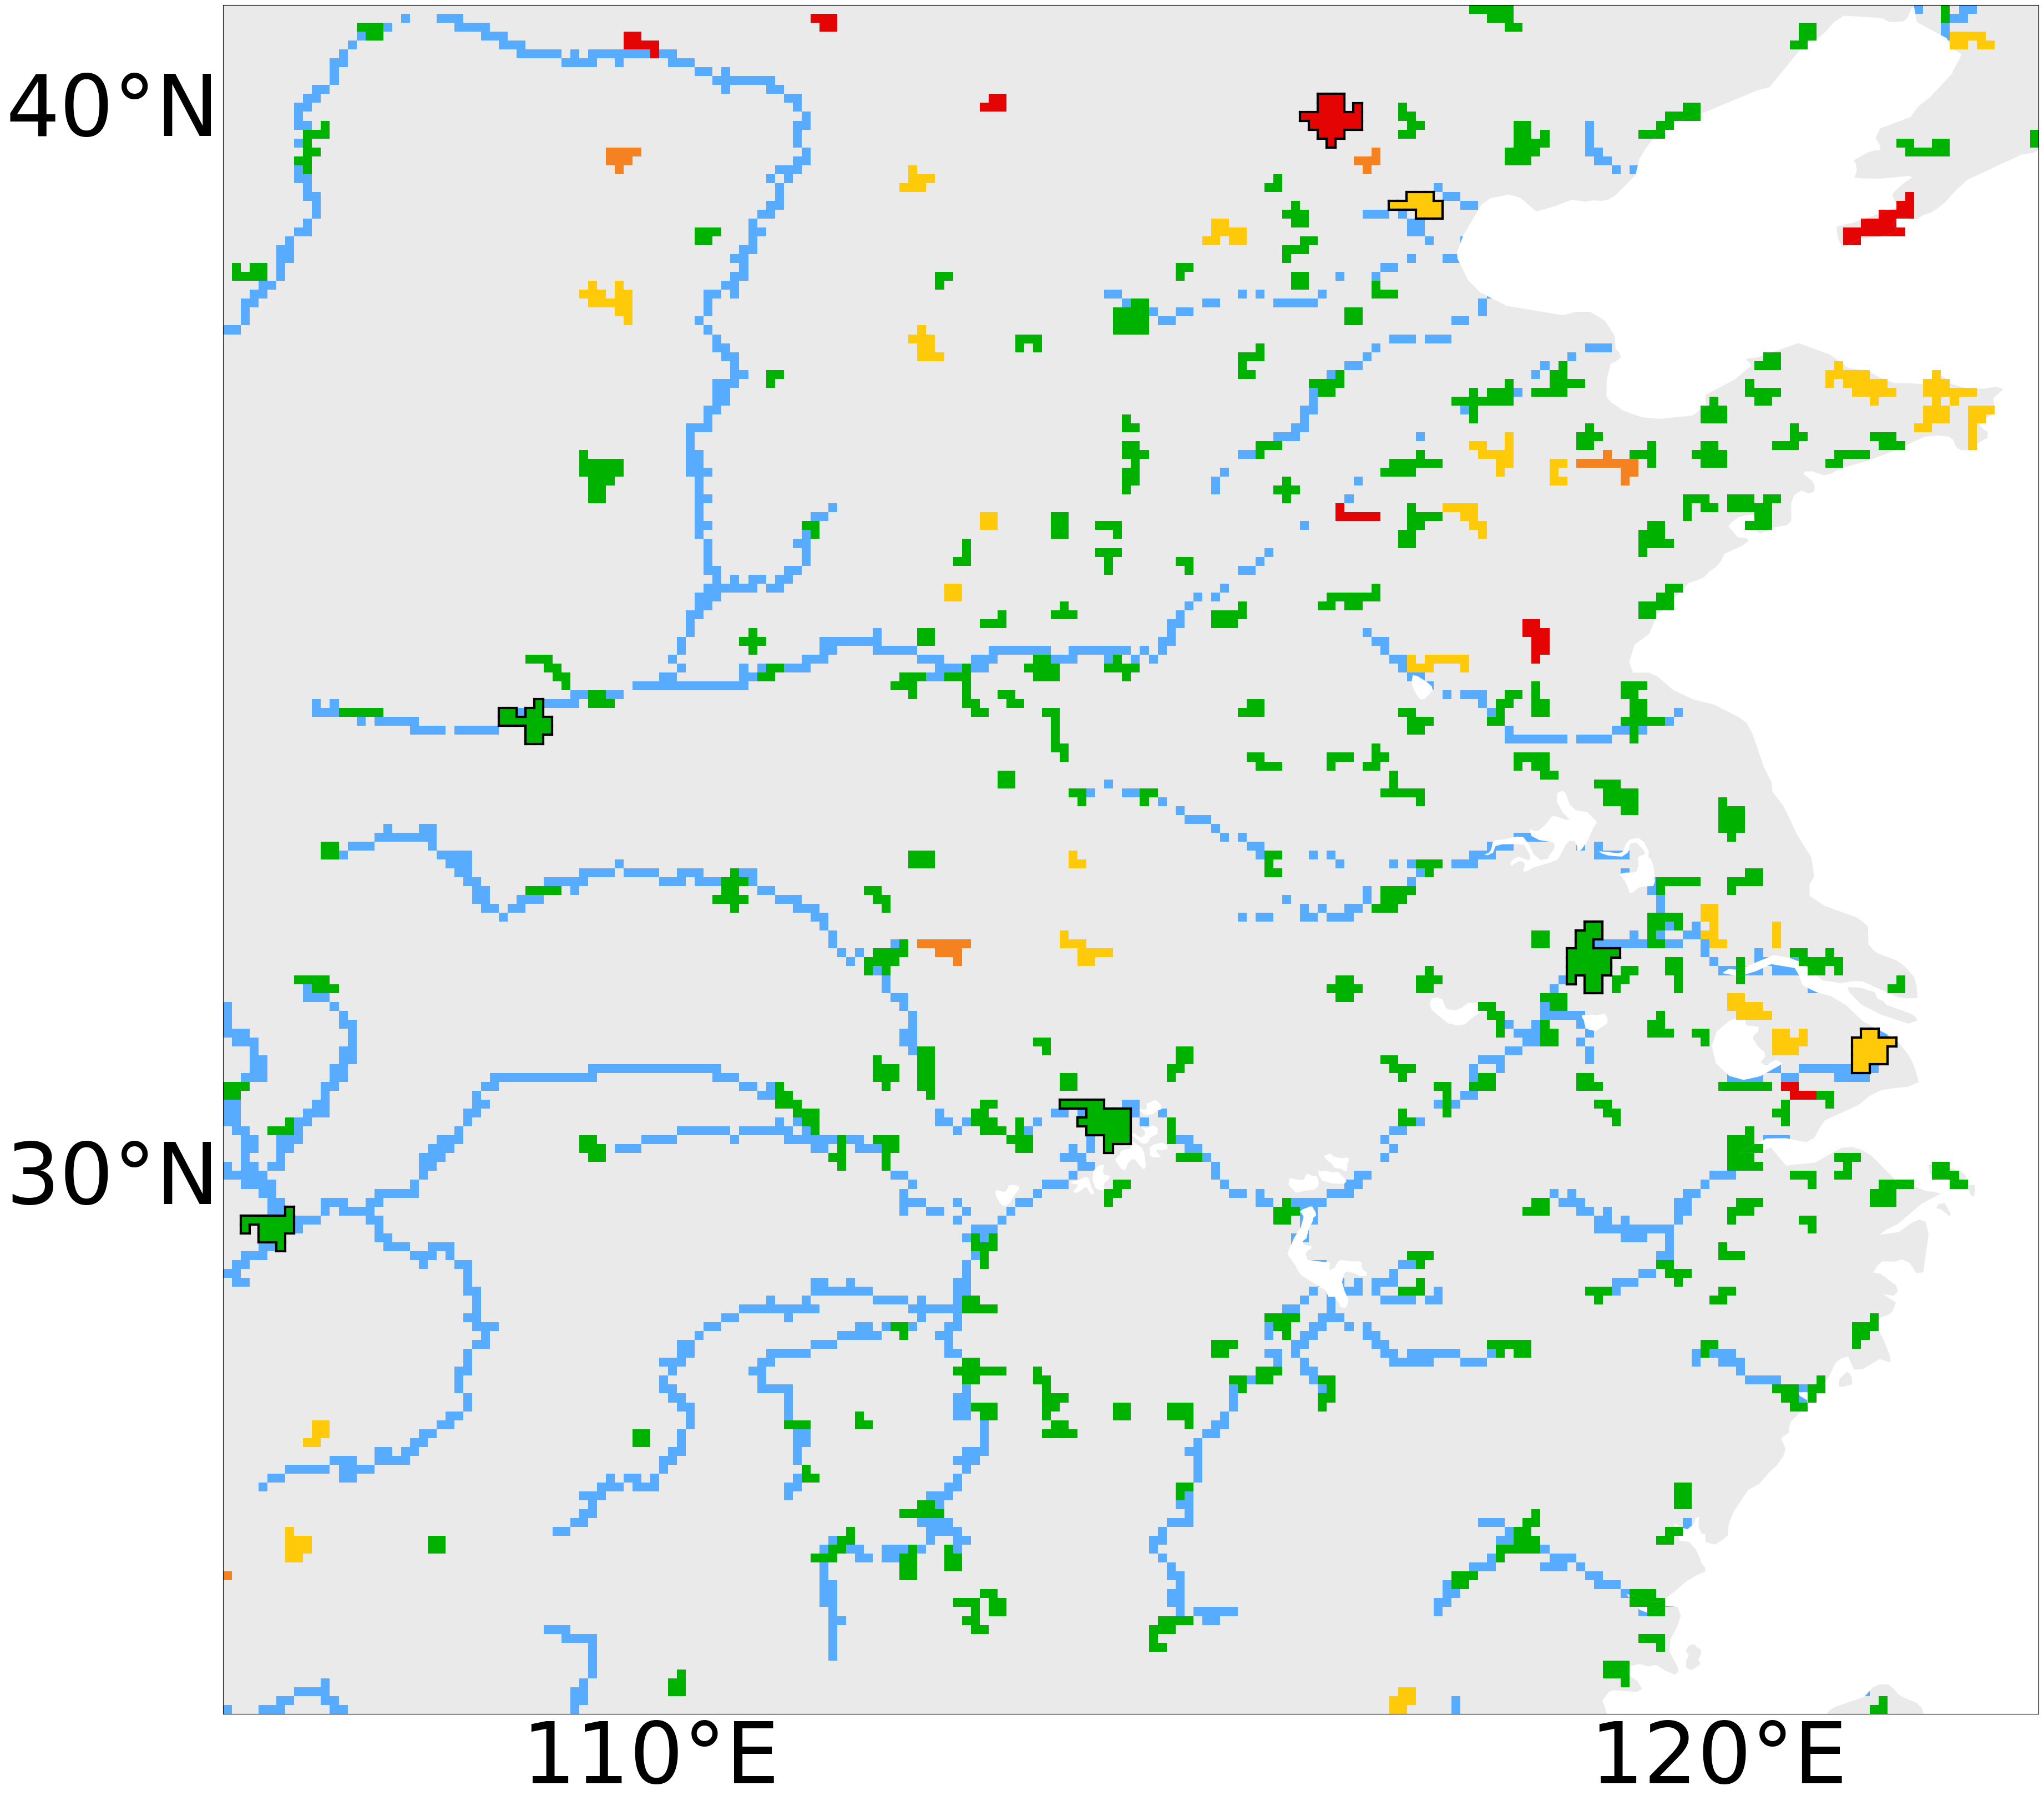

In [26]:
# paper review

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker

#各都市が利用する主河道のみを記述する方法

def geography(left, right, bottom, top):
    #
    resolution = 12
    #
    upperindex = (90-top)*resolution
    lowerindex = (90-bottom)*resolution
    leftindex = (180+left)*resolution
    rightindex = (180+right)*resolution
    #
    rgnshape = (lowerindex-upperindex, rightindex-leftindex)
    #
    img_extent = (left, right, bottom, top)
    
    return upperindex, lowerindex, leftindex, rightindex, rgnshape, img_extent

def draw_mask_sotowaku_outer(extent, mask_cropped, ax=None, sotowaku_color='#dc143c', linewidth=5, padding=0.1, pop_thres=5e6):
    """
    zorder = 0: デフォルトの最背面(gridをzorder=0に設定)
    zorder = 1: 赤色の外枠(citymask)
    
    extent: (x_left, x_right, y_bottom, y_top)
    mask_cropped: マスクされた都市域の2D配列
    ax: プロットする軸
    sotowaku_color: 枠線の色
    linewidth: 枠線の太さ
    padding: 枠線を外側にシフトさせる量（度単位）
    """
    mask_cropped = np.ma.filled(mask_cropped, 0)

    # delta
    delta = 360/4320
    x_left = extent[0]
    y_top = extent[3]
    
    # outer
    upper_indices = []
    lower_indices = []
    left_indices = []
    right_indices = []
    rows, cols = mask_cropped.shape
    for i in range(rows-1):
        for j in range(cols-1):
            if mask_cropped[i, j] > pop_thres and mask_cropped[i, j] != 0:
                if i > 0 and mask_cropped[i-1, j] == 0:
                    upper_indices.append((i, j))
                if i < rows-1 and mask_cropped[i+1, j] == 0:
                    lower_indices.append((i, j))
                if j > 0 and mask_cropped[i, j-1] == 0:
                    left_indices.append((i, j))
                if j < cols-1 and mask_cropped[i, j+1] == 0:
                    right_indices.append((i, j))

    # extent
    projection = ccrs.PlateCarree()

    # city mask
    for up in upper_indices:
        x_index = x_left + delta*(up[1])
        y_index = y_top - delta*(up[0]) + padding * delta
        ax.plot([x_index, x_index+delta], [y_index, y_index], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # top
    for lo in lower_indices:
        x_index = x_left + delta*(lo[1])
        y_index = y_top - delta*(lo[0]+1) - padding * delta
        ax.plot([x_index, x_index+delta], [y_index, y_index], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # bottom
    for le in left_indices:
        x_index = x_left + delta*(le[1]) - padding * delta
        y_index = y_top - delta*(le[0]+1)
        ax.plot([x_index, x_index], [y_index, y_index+delta], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # left
    for ri in right_indices:
        x_index = x_left + delta*(ri[1]+1) + padding * delta
        y_index = y_top - delta*(ri[0]+1)
        ax.plot([x_index, x_index], [y_index, y_index+delta], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # right

    return ax

def east_asia_plot(left, right, bottom, top, linewidth=5, padding=0.1):
    # init 
    pop_thres=5e6
    threshold = 5*1e6*1000

    # path
    h08dir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08'
    upperindex, lowerindex, leftindex, rightindex, rgnshape, img_extent = geography(left, right, bottom, top)
    
    # wsi/pre/population_m3year.ipynb
    population_path = f'{h08dir}/wsi/dat/population/population_threshold_world.npy'
    population = np.load(population_path)
    population_cropped = population[upperindex:lowerindex, leftindex:rightindex]
    
    # wsi/pre/availability_m3year.ipynb
    availability_path = f'{h08dir}/wsi/dat/availablewater/availablewater_threshold_world.npy'
    availability = np.load(availability_path)
    availability_cropped = availability[upperindex:lowerindex, leftindex:rightindex]

    # wsi/pst/MPCY_background.ipynb
    riv_path_array_path = f'{h08dir}/wsi/dat/riv_path/riv_path_array.gl5'
    riv_path_array = np.fromfile(riv_path_array_path, dtype='float32').reshape(2160, 4320)
    
    # wsi/pre/MPCY_citylonlat_citygrid.ipynb
    grid_path = f'{h08dir}/wsi/dat/cmy/world_citygrid_100km_abandon.npy'
    citygrid = np.load(grid_path)
    citygrid_masked = np.ma.masked_where(citygrid==0, citygrid)
    region = citygrid_masked[upperindex:lowerindex, leftindex:rightindex]
    region_masked = np.ma.masked_where(region==0, region)

    # discharge
    riv_path = f'{h08dir}/wsi/dat/riv_out_/W5E5LR__00000000.gl5'
    rivout = np.fromfile(riv_path, dtype='float32').reshape(2160, 4320)
    rivout_tmp = np.ma.masked_where(riv_path_array==0, rivout)
    rivout_cropped = rivout_tmp[upperindex:lowerindex, leftindex:rightindex] * 60 * 60 * 24 * 365 / 1000
    rivout_masked = np.ma.masked_where(rivout_cropped==0, rivout_cropped)
    rivout_thres = np.ma.masked_where(rivout_masked<threshold, rivout_masked)
    
    bounds = [0, 100, 300, 1000, 1700]
    cmap = mcolors.ListedColormap(['#e40404', '#f58220', '#feca0a', '#00b200'])
    norm = mcolors.BoundaryNorm(bounds, cmap.N)
    
    plt.rcParams["font.size"] = 50
    projection = ccrs.PlateCarree()
    fig, ax = plt.subplots(figsize=(50,40), subplot_kw={'projection': projection})

    river_cmap = mcolors.ListedColormap(['#57acff'])
    imr = ax.imshow(rivout_thres, 
                    extent=img_extent,
                    cmap=river_cmap,
                    transform=projection,
                    zorder=-2
                   )
    
    imd = ax.imshow(region_masked, 
                  cmap= cmap,
                  norm = norm,
                  extent=img_extent,
                  transform=projection, 
                 )
    
    ax.add_feature(cfeature.LAND, edgecolor='none', facecolor='#eaeaea', zorder=-3)
    ax.add_feature(cfeature.OCEAN, edgecolor='none', facecolor='#ffffff')
    ax.add_feature(cfeature.LAKES, edgecolor='none', facecolor='#ffffff', zorder=-1)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.1,edgecolor='#d0cfd4')
    ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=1.5, edgecolor='#d0cfd4', zorder=-3)
    
    gl = ax.gridlines(draw_labels=True, zorder=2, color='gray', alpha=0.5, linestyle='--')
    gl.xlocator = mticker.FixedLocator(np.arange(round(left/10)*10, right, 10))
    gl.ylocator = mticker.FixedLocator(np.arange(round(bottom/10)*10, top, 10))
    gl.top_labels = False
    gl.right_labels = False
    gl.bottom_labels = True
    gl.left_labels = True
    gl.xlines = False
    gl.ylines = False
    gl.xlabel_style = {'size': 110, 'color': 'black'}
    gl.ylabel_style = {'size': 110, 'color': 'black'}
    
    ax.gridlines(visible=False)
    ax.spines['geo'].set_visible(True)
    
    #cbar = fig.colorbar(imd, ax=ax, orientation='horizontal', pad=0.02)
    draw_mask_sotowaku_outer(img_extent, population_cropped, ax=ax, sotowaku_color='black', linewidth=linewidth, padding=padding, pop_thres=pop_thres)
    plt.show()

linewidth = 3
padding = 0.0
east_asia_plot(106, 123, 25, 41, linewidth=linewidth, padding=padding)

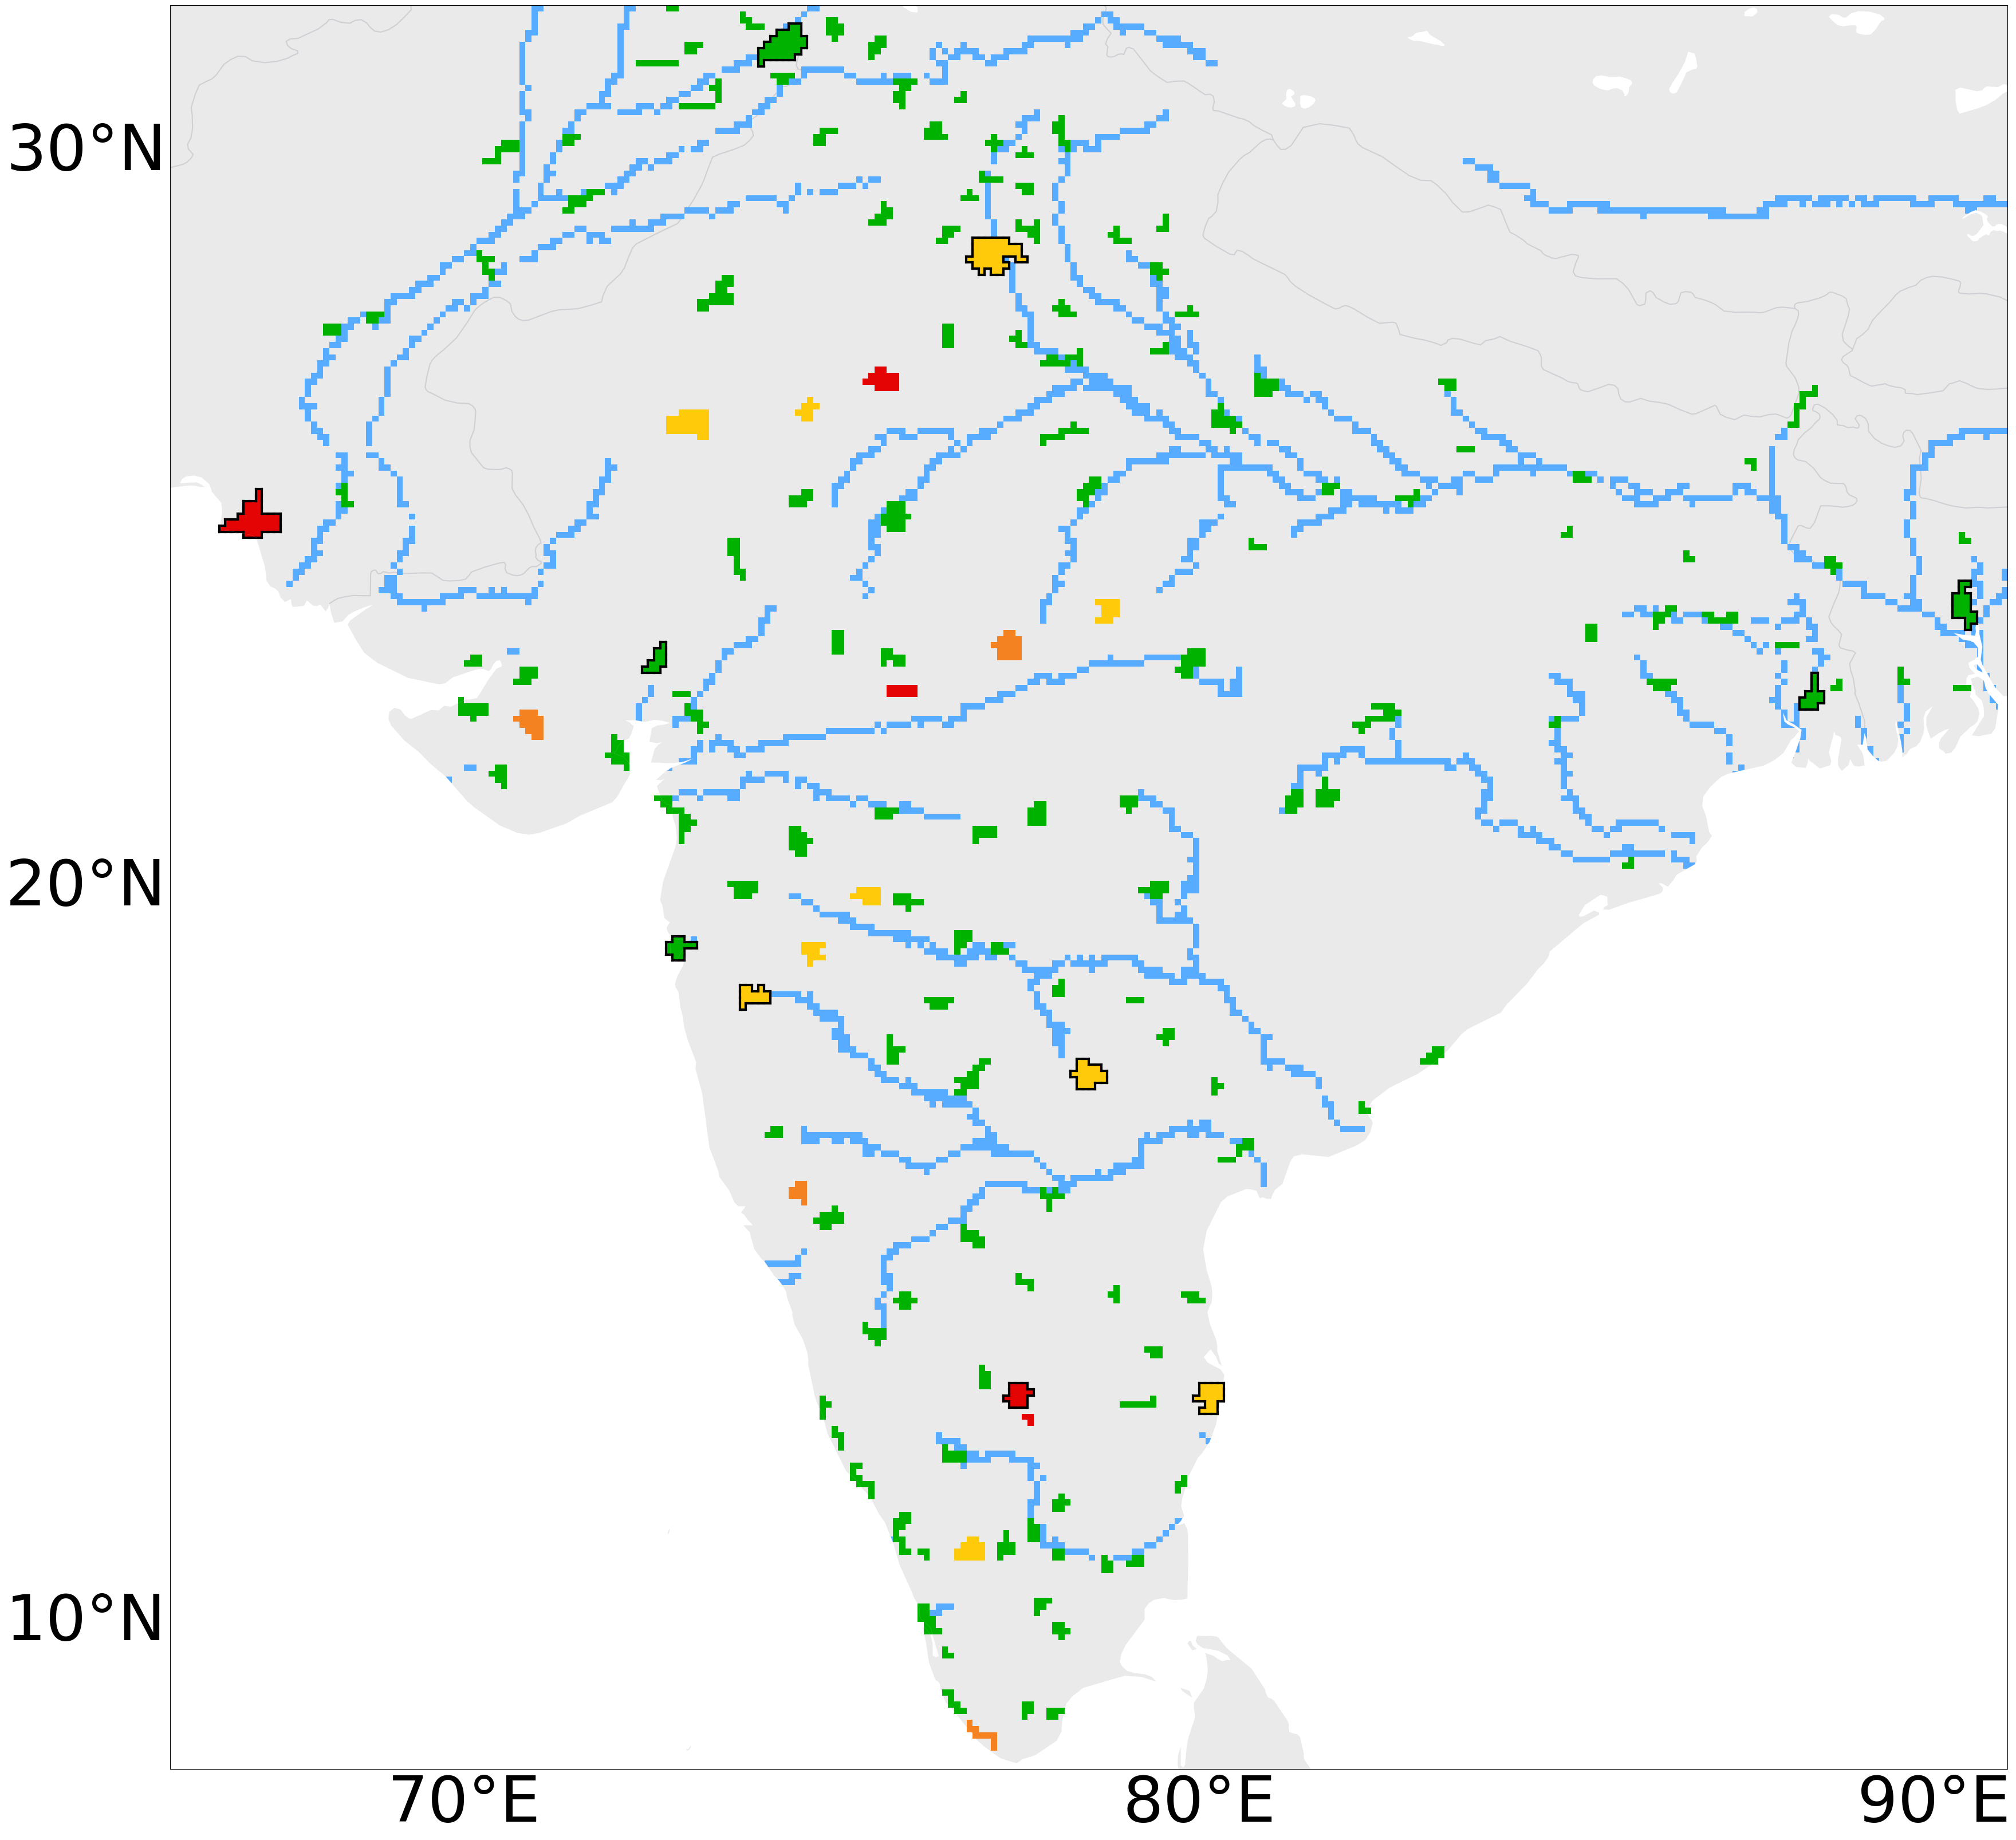

In [27]:
paper_plot(66, 91, 8, 32, linewidth=linewidth, padding=padding)

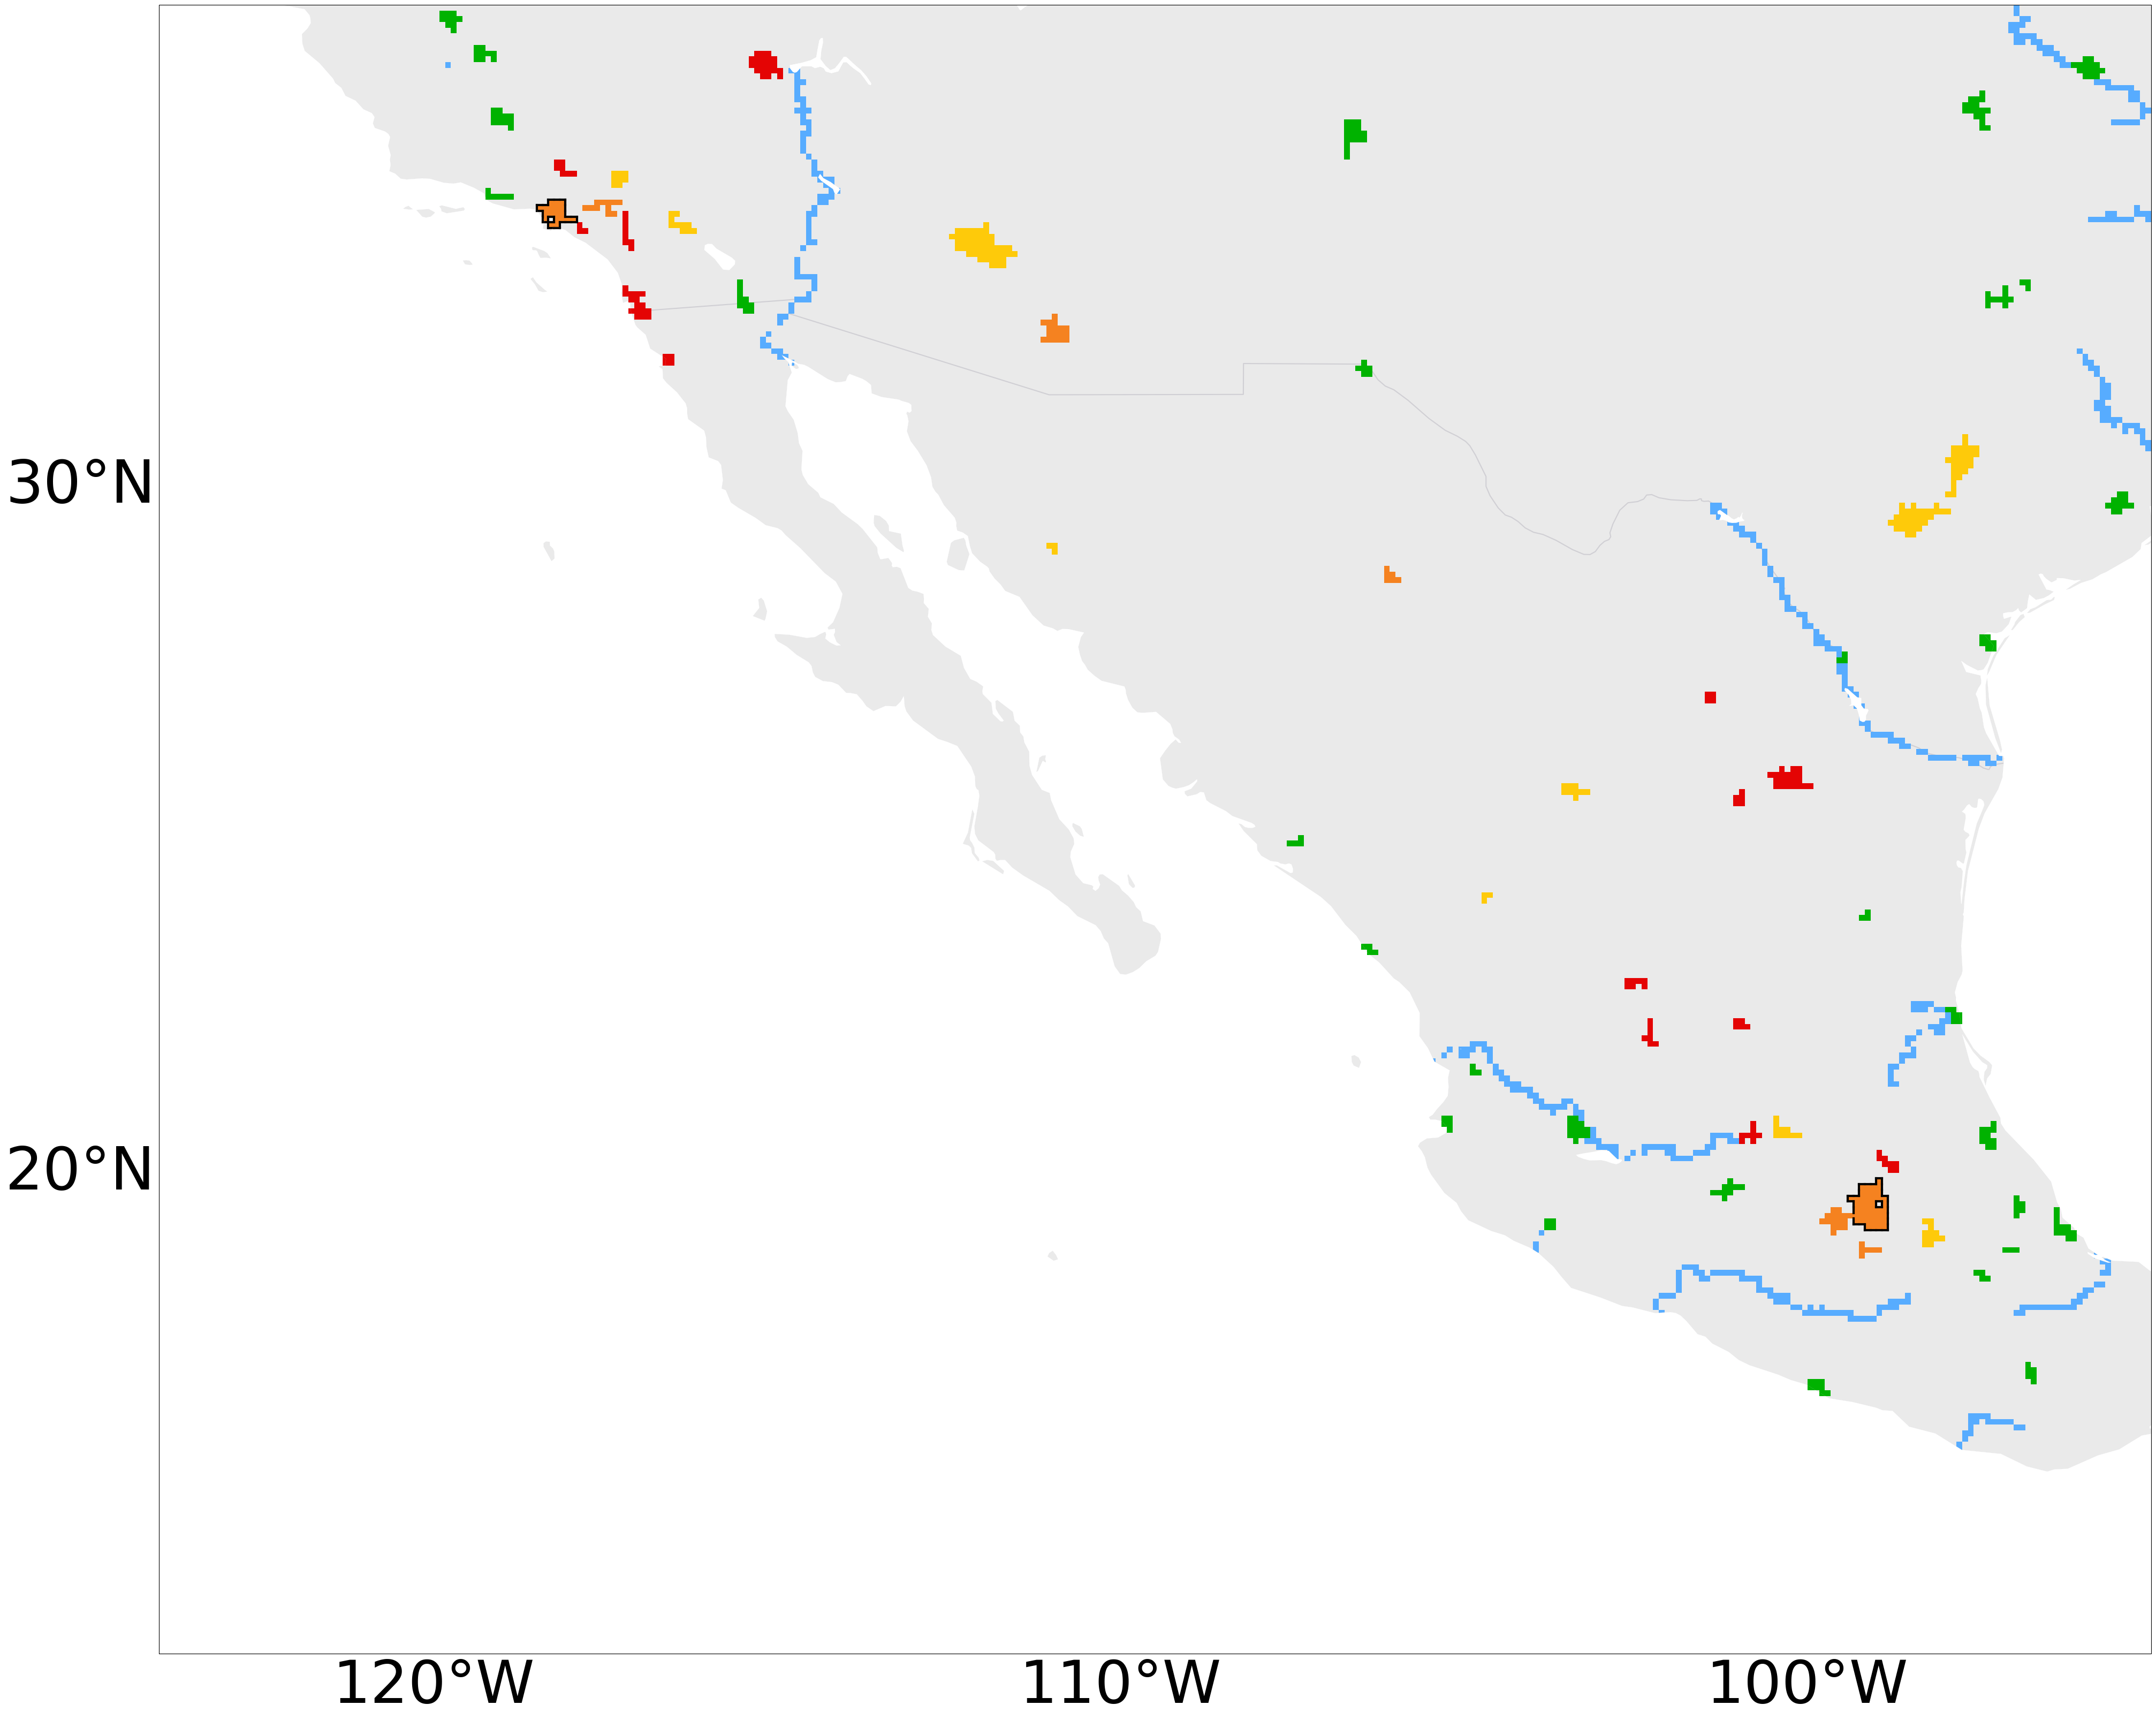

In [28]:
paper_plot(-124, -95, 13, 37, linewidth=linewidth, padding=padding)

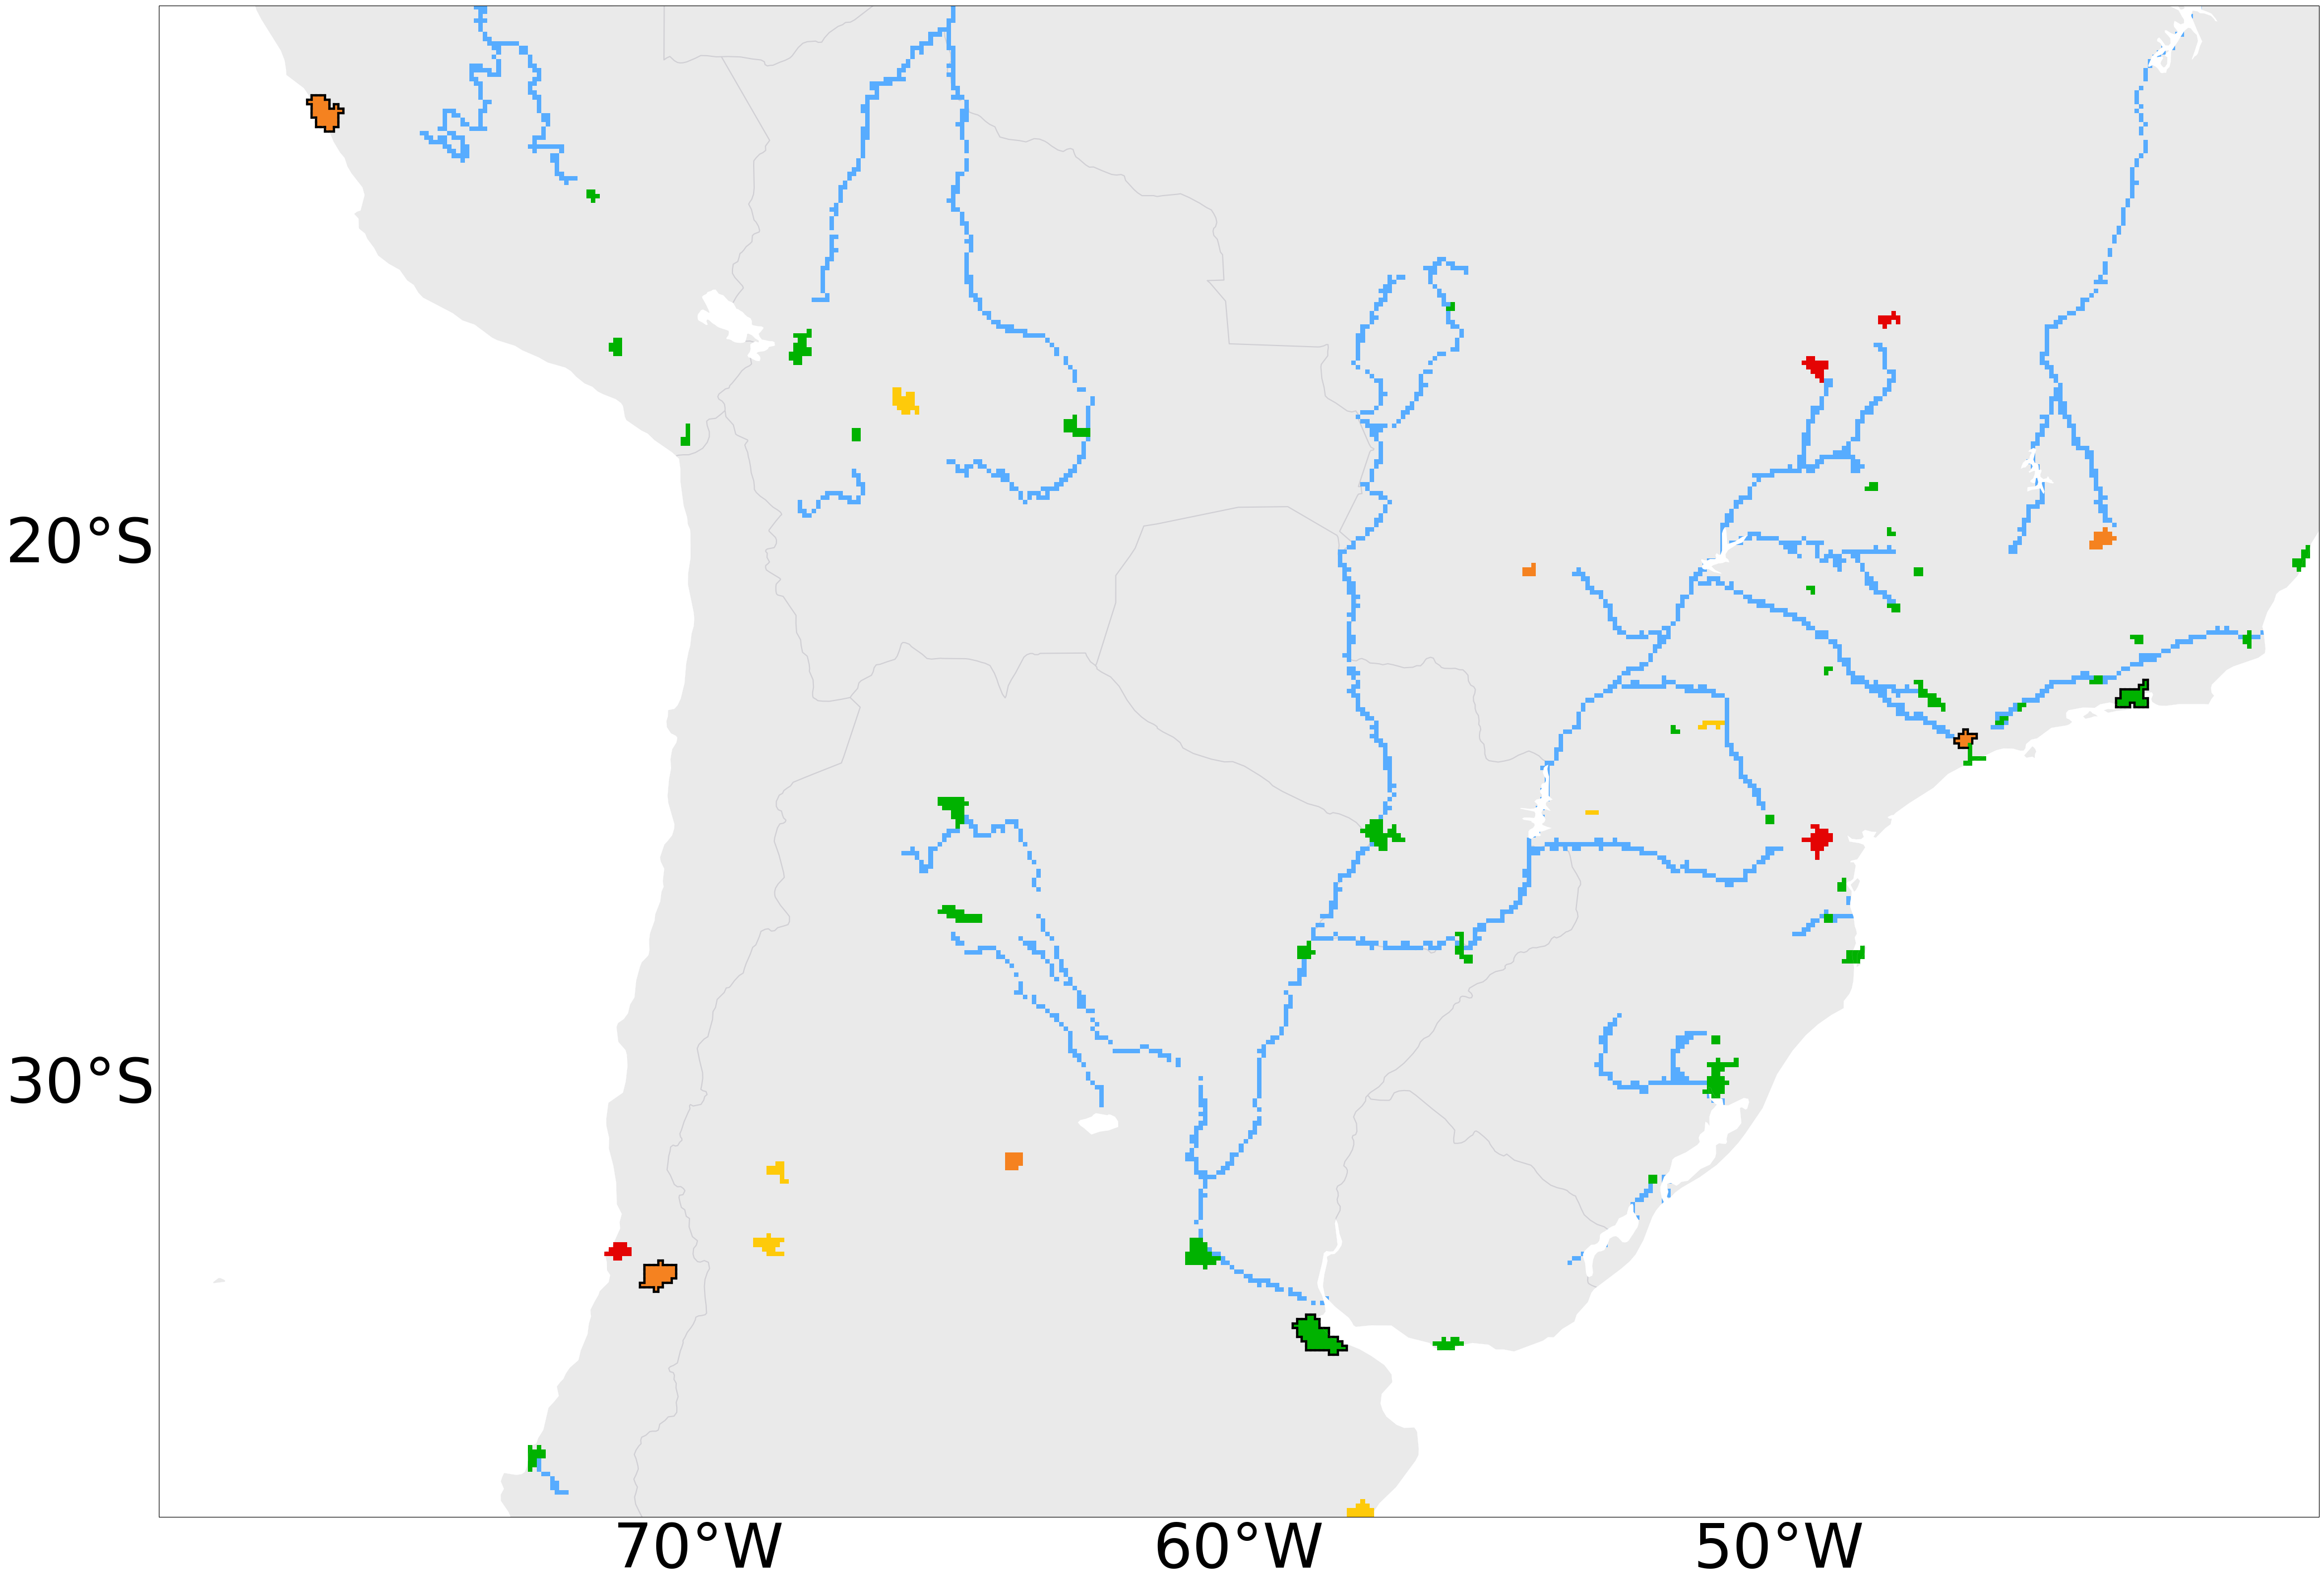

In [29]:
paper_plot(-80, -40, -38, -10, linewidth=linewidth, padding=padding)

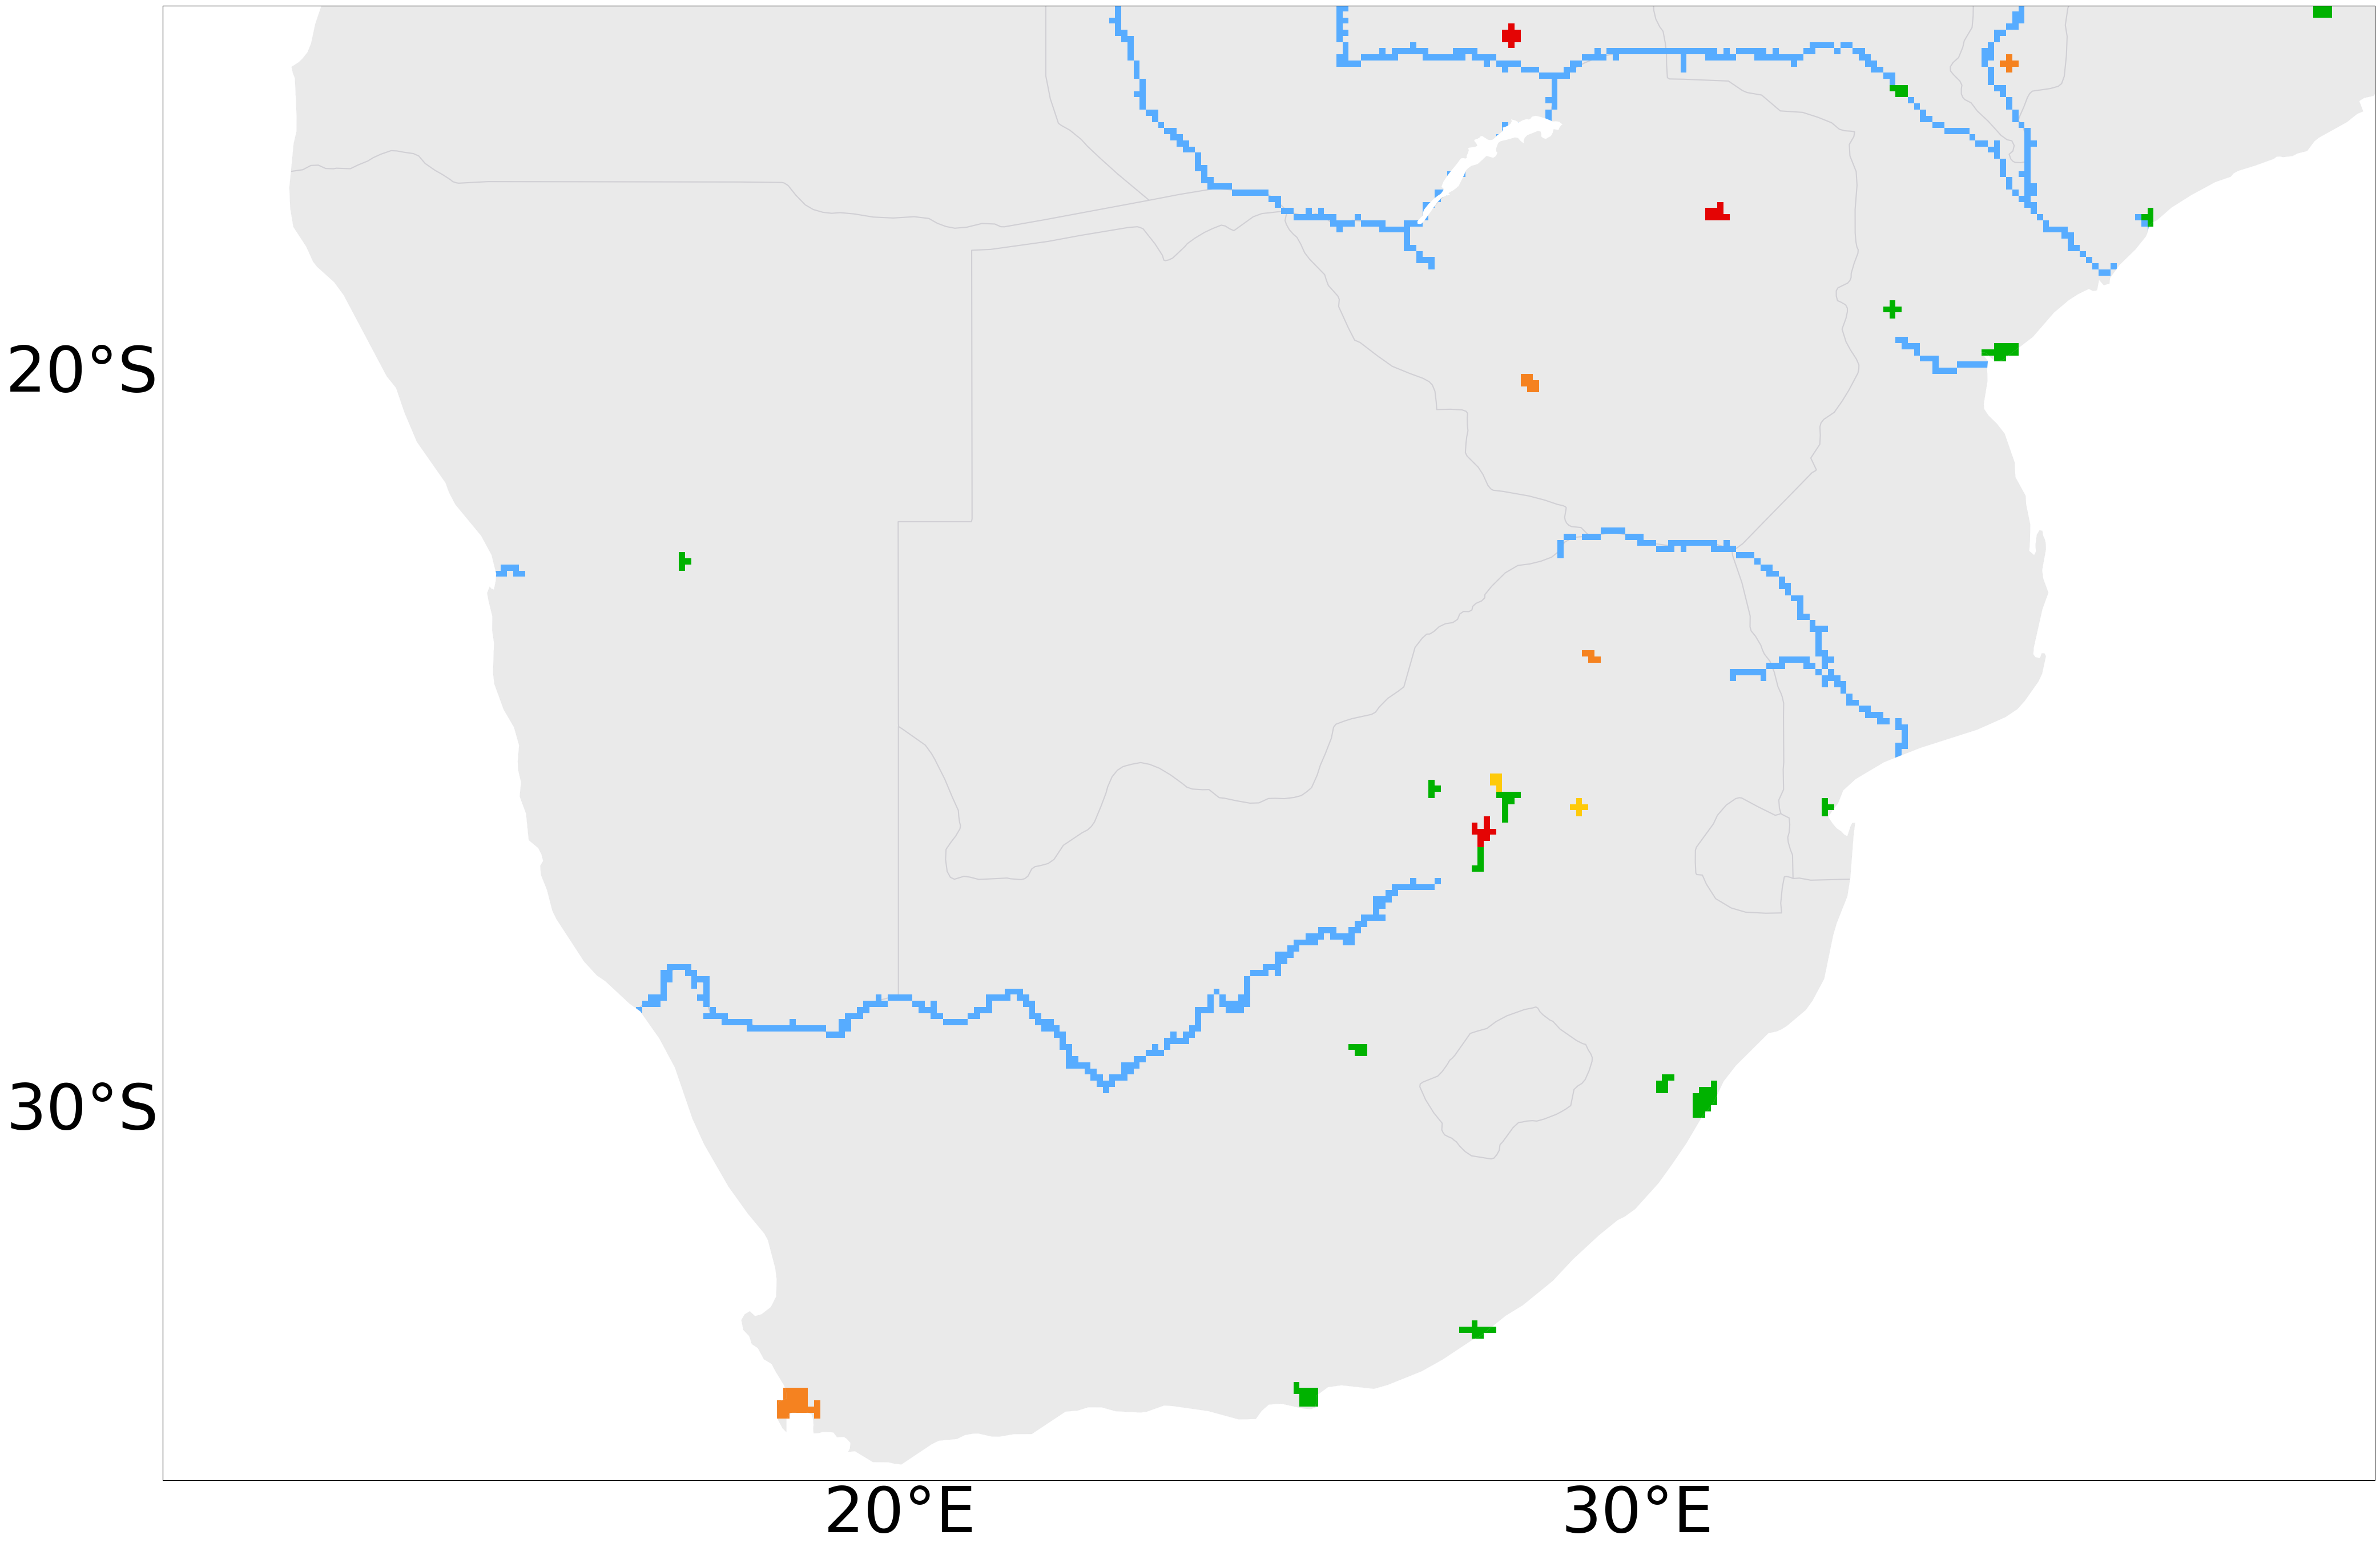

In [30]:
paper_plot(10, 40, -35, -15, linewidth=linewidth, padding=padding)